# DLCV Assignment 1

**Due Date: 17/02/2023 11:59PM IST**

**Name: Kedarnath P**

**Sr. No.: 20902**


In this assignment, we will cover the following topics:

1) Training a simple Linear Model 

2) Implementing Modules with Backprop functionality

3) Implementing Convolution Module on Numpy


It is crucial to get down to the nitty gritty of the code to implement all of these. No external packages (like caffe,pytorch etc), which directly give functions for these steps, are to be used. 

# Training a simple Linear Model

In this section, you will write the code to train a Linear Model. The goal is to classify an input $X_i$ of size $n$ into one of $m$ classes. For this, you need to consider the following:

1)  **Weight Matrix** $W_{n\times m}$: The Weights are multipled with the input $X_i$ (vector of size $n$), to find $m$ scores $S_m$ for the $m$ classes.

2)  **The Loss function**:   
  * The Cross Entropy Loss: By interpreting the scores as unnormalized log probabilities for each class, this loss tries to measure dissatisfaction with the scores in terms of the log probability of the right class:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where $f_{ y_i }$ is the $y_i$-th element of the output of $W^T  X_i$

3) **A Regularization term**: In addition to the loss, you need a Regularization term to lead to a more distributed (in case of $L_2$) or sparse (in case of $L_1$) learning of the weights. For example, with $L_2$ regularization, the loss has the following additional term:

$$
R(W) = \sum_k\sum_l W_{k,l}^2  
$$

Thus the total loss has the form:
$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \lambda R(W) }_\text{regularization loss} \\\\
$$

4) **An Optimization Procedure**: This refers to the process which tweaks the weight Matrix $W_{n\times m}$ to reduce the loss function $L$. In our case, this refers to Mini-batch Gradient Descent algorithm. We adjust the weights $W_{n\times m}$, based on the gradient of the loss $L$ w.r.t. $W_{n\times m}$. This leads to:
$$
W_{t+1} = W_{t} - \alpha \frac{\partial L}{\partial W},
$$
where $\alpha$ is the learning rate. Additionally, with "mini-batch" gradient descent, instead of finding loss over the whole dataset, we use a small sample $B$ of the training data to make each learning step. Hence,
$$
W_{t+1} = W_{t} - \alpha \frac{\partial \sum_{i \in B}{L_{x_i}}}{\partial W},
$$
where $|B|$ is the batch size.

# Question 1

Train a **Single-Layer Classifier** for the MNIST dataset. 
* Use Softmax-Loss.
* Maintain a train-validation split of the original training set for finding the right value of $\lambda$ for the regularization, and to check for over-fitting.
* Finally, evaluate the classification performance on the test-set.


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm.notebook import tqdm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



In [4]:
import numpy as np
import os
import struct

def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels.idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images.idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels




In [5]:
# Load the data
X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training data into training and validation sets
train_size = int(X_train.shape[0] * 0.8)

X_val = X_train[train_size:]
y_val = y_train[train_size:]

X_train = X_train[:train_size]
y_train = y_train[:train_size]

In [6]:

# Print the shapes of the data sets
print("Train data shape: ", X_train.shape)
print("Label data shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Test data shape: ", X_test.shape)


Train data shape:  (48000, 784)
Label data shape:  (48000,)
Validation data shape:  (12000, 784)
Test data shape:  (10000, 784)


### Sample image from MNIST dataset

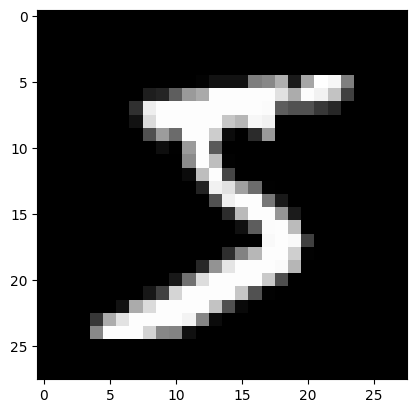

In [7]:

# Reshape the image to its original size (28x28)
image = X_train[0].reshape(28, 28)

# Plot the image
plt.imshow(image, cmap='gray')
plt.show()


In [8]:
# Define the class for a Single Layer Classifier

class Single_layer_classifier():
    
    def __init__(self, input_size, output_size):
        self.W = np.random.normal(0, 1e-3, (input_size, output_size)) 
        self.b = np.zeros((1, output_size))

    def forward(self, input_x):
        scores = np.dot(input_x, self.W) + self.b
        return scores
    
    def backward_Ldata(self, grad_from_loss, input_x):
        grad_matrix = np.dot(input_x.T, grad_from_loss)
        grad_b = np.sum(grad_from_loss, axis=0)
        return grad_matrix, grad_b
        
    def backward_Lreg(self, lmbda):
        grad_matrix = 2 * lmbda * self.W
        return grad_matrix


In [9]:
# Implement the Softmax loss function

def softmax(scores):
    scores -= np.max(scores)
    probabilities = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
    return probabilities

def loss_function(input_y, scores, lmbda, W):
    num_examples = scores.shape[0]
    probabilities = softmax(scores)
    
    corect_logprobs = -np.log(probabilities[range(num_examples),input_y])
    data_loss = np.sum(corect_logprobs) / num_examples
    reg_loss = 0.5 * lmbda * np.sum(W * W)
    loss = data_loss + reg_loss
    
    dscores = probabilities
    dscores[range(num_examples),input_y] -= 1
    dscores /= num_examples
    
    return loss, dscores


### Create utility function for calculating training and validation accuracy

In [10]:
def calculate_accuracy(X, y, model):
    scores = model.forward(X)
    predicted_class = np.argmax(scores, axis=1)
    accuracy = np.mean(predicted_class == y)
    return accuracy


In [11]:

# Create an instance of Single_layer_classifier
input_size = X_train.shape[1]  # 784
num_classes = output_size = 10
model = Single_layer_classifier(input_size, output_size)


# weights and biases initialization
W = np.random.normal(0, 1e-3, (X_train.shape[1], num_classes))
#b = np.random.randn(num_classes)

b = np.zeros((1, num_classes))



In [12]:

# Set hyperparameters

# Learning rate decay
decay_rate = 0.95
learning_rate = 1e-3

lmbda = 1e-3   #regularization coeff
num_epochs = 20
batch_size = 64


In [13]:
#This function takes as input the training input features x_train, training target labels y_train, and the desired batch size batch_size. 
#It generates a random set of indices from the training set and divides them into mini-batches of size batch_size. 
#For each mini-batch, it selects the corresponding input features and target labels and yields them.

def get_minibatch(batch_size=batch_size):
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    
    for i in range(0, X_train.shape[0] - batch_size + 1, batch_size):
        batch_indices = indices[i:i+batch_size]
        yield X_train[batch_indices], y_train[batch_indices]


In [14]:
# Finally the trainer:
# Make an instance of Single_layer_classifier
# Train for t epochs:
###  Train on the train-set obtained from train-validation split
###  Use the mini-batch generator to get each mini-batch


# Lists to store performance data for plotting
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []


# Training loop
for epoch in tqdm(range(num_epochs)):
    losses = []
    learning_rate *= decay_rate
    for input_x, input_y in get_minibatch(batch_size):
        # Forward pass
        scores = model.forward(input_x)
        
        # Calculate loss and gradient
        loss, dscores = loss_function(input_y, scores, lmbda, model.W)
        losses.append(loss)
        
        # Backward pass
        grad_W, grad_b = model.backward_Ldata(dscores, input_x)
        grad_W += model.backward_Lreg(lmbda)
        
        # Update weights and bias
        model.W -= learning_rate * grad_W
        model.b -= learning_rate * grad_b

    # After each epoch, calculate and print loss and accuracy
    avg_train_loss = np.mean(losses)  # average loss of all batches

    # Calculate validation loss
    val_scores = model.forward(X_val)  # output values
    val_loss, _ = loss_function(y_val, val_scores, lmbda, model.W)  # for entire validation dataset 

    train_acc = calculate_accuracy(X_train, y_train, model)
    val_acc = calculate_accuracy(X_val, y_val, model)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

    # Store loss and accuracy for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.9866, Val Loss: 1.7071, Train Accuracy: 75.92%, Val Accuracy: 77.28%
Epoch 2/20, Train Loss: 1.5447, Val Loss: 1.3704, Train Accuracy: 78.81%, Val Accuracy: 80.83%
Epoch 3/20, Train Loss: 1.2888, Val Loss: 1.1683, Train Accuracy: 80.41%, Val Accuracy: 82.38%
Epoch 4/20, Train Loss: 1.1298, Val Loss: 1.0373, Train Accuracy: 81.59%, Val Accuracy: 83.32%
Epoch 5/20, Train Loss: 1.0234, Val Loss: 0.9466, Train Accuracy: 82.35%, Val Accuracy: 83.91%
Epoch 6/20, Train Loss: 0.9476, Val Loss: 0.8804, Train Accuracy: 82.95%, Val Accuracy: 84.42%
Epoch 7/20, Train Loss: 0.8910, Val Loss: 0.8302, Train Accuracy: 83.45%, Val Accuracy: 84.76%
Epoch 8/20, Train Loss: 0.8472, Val Loss: 0.7907, Train Accuracy: 83.74%, Val Accuracy: 85.08%
Epoch 9/20, Train Loss: 0.8123, Val Loss: 0.7589, Train Accuracy: 84.05%, Val Accuracy: 85.40%
Epoch 10/20, Train Loss: 0.7838, Val Loss: 0.7328, Train Accuracy: 84.34%, Val Accuracy: 85.75%
Epoch 11/20, Train Loss: 0.7602, Val Loss: 0.7109

### Plotting the training loss vs validation loss

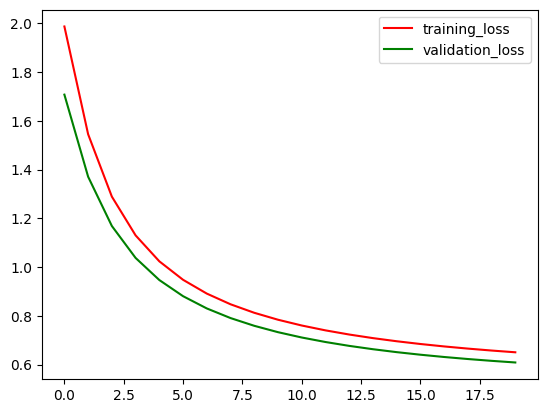

In [15]:
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(val_loss_history, color="g", label="validation_loss")
plt.legend()
plt.show()

### Plot the training loss and training accuracy plot

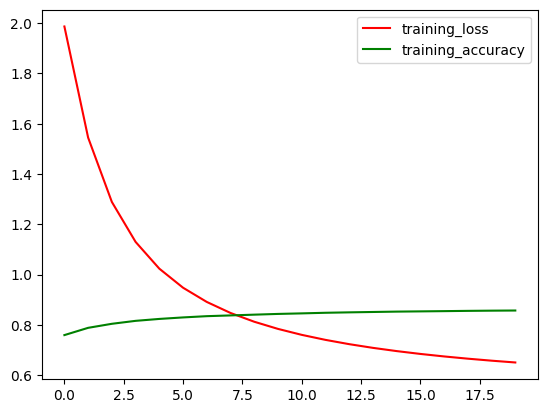

In [17]:
# WRITE CODE HERE
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(train_accuracy_history, color="g", label="training_accuracy")
plt.legend()
plt.show()

### Find the accuracy on the validation set

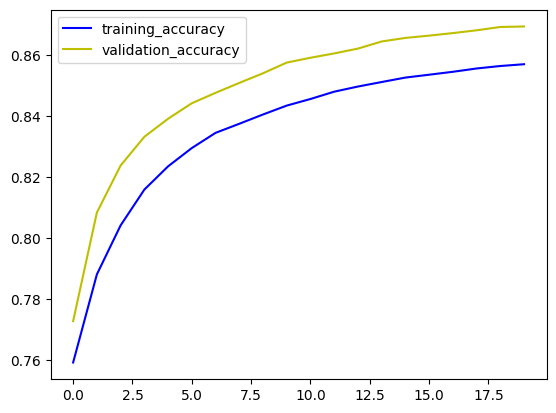

In [18]:
# WRITE CODE HERE

plt.plot(train_accuracy_history, color="b", label="training_accuracy")
plt.plot(val_accuracy_history, color="y", label="validation_accuracy")
plt.legend()
plt.show()



### Accuracy of the model on train and test data.

In [21]:
# Calculate accuracy on the training data
train_accuracy = calculate_accuracy(X_train, y_train, model)
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

# Calculate accuracy on the testing data
test_accuracy = calculate_accuracy(X_test, y_test, model)
print(f'Testing accuracy: {test_accuracy * 100:.2f}%')


Training accuracy: 85.70%
Testing accuracy: 86.92%


### *Observation:* 
We can see that the model has been trained properly and there is no sign of over-fitting as the training and validation/test accuracies are nearly similar (there is no huge gap between them).

###  Grid search: Tuning the hyper parameters learning rate and lambda(regularization coefficient) .

In [35]:
# Define the hyperparameters to search over
learning_rates = [1e-3, 1e-4, 1e-5]
regularization_strengths = [1e-3, 1e-4, 1e-5]

# Initialize variables to store the best model and the highest validation accuracy
best_model = None
best_val_accuracy = -1

# Grid search over the hyperparameters
for lr in learning_rates:
    for lmbda in regularization_strengths:
        # Train a model with the current hyperparameters
        model = Single_layer_classifier(input_size, output_size)
        for epoch in tqdm(range(num_epochs)):
            for input_x, input_y in get_minibatch(batch_size):
                scores = model.forward(input_x)
                loss, dscores = loss_function(input_y, scores, lmbda, model.W)
                grad_W, grad_b = model.backward_Ldata(dscores, input_x)
                grad_W += model.backward_Lreg(lmbda)
                model.W -= lr * grad_W
                model.b -= lr * grad_b
        
        # Evaluate the model on the validation set
        val_acc = calculate_accuracy(X_val, y_val, model)
        
        # If the model is better than the best model so far, store it
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model = model
            best_learning_rate = lr
            best_lambda = lmbda
        
        print(f"Learning rate: {lr}, Regularization_coefficient: {lmbda}, Validation accuracy: {val_acc}")
        
print(f"\nBest lambda: {best_lambda}, Best learning rate: {best_learning_rate}, Best validation accuracy: {best_val_accuracy}")
        


  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate: 0.001, Regularization_coefficient: 0.001, Validation accuracy: 0.8800833333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate: 0.001, Regularization_coefficient: 0.0001, Validation accuracy: 0.88


  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate: 0.001, Regularization_coefficient: 1e-05, Validation accuracy: 0.8801666666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate: 0.0001, Regularization_coefficient: 0.001, Validation accuracy: 0.8115


  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate: 0.0001, Regularization_coefficient: 0.0001, Validation accuracy: 0.8119166666666666


  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate: 0.0001, Regularization_coefficient: 1e-05, Validation accuracy: 0.8108333333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate: 1e-05, Regularization_coefficient: 0.001, Validation accuracy: 0.7241666666666666


  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate: 1e-05, Regularization_coefficient: 0.0001, Validation accuracy: 0.73675


  0%|          | 0/20 [00:00<?, ?it/s]

Learning rate: 1e-05, Regularization_coefficient: 1e-05, Validation accuracy: 0.7284166666666667

Best lambda: 1e-05, Best learning rate: 0.001, Best validation accuracy: 0.8801666666666667


### Report final performance on MNIST test set

In [36]:
print("After hyper parameters tuning:\n")


# Calculate accuracy on the training data
train_accuracy = calculate_accuracy(X_train, y_train, best_model)
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

# Calculate accuracy on the testing data
test_accuracy = calculate_accuracy(X_test, y_test, best_model)
print(f'Testing accuracy: {test_accuracy * 100:.2f}%')



After hyper parameters tuning:

Training accuracy: 86.94%
Testing accuracy: 88.10%


### Find the best performing class and the worst performing class

In [37]:
# Calculate confusion matrix
y_pred = np.argmax(best_model.forward(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

# Calculate class-wise accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Find best and worst classes
best_class = np.argmax(class_accuracy)
worst_class = np.argmin(class_accuracy)

print(f"Best performing class: {best_class}, accuracy: {class_accuracy[best_class] * 100:.2f}%")
print(f"Worst performing class: {worst_class}, accuracy: {class_accuracy[worst_class] * 100:.2f}%")

Best performing class: 0, accuracy: 96.94%
Worst performing class: 5, accuracy: 76.23%


## BONUS Question
### Observe the effect on test set accuracy by changing the number of training samples.
### Train on 10%, 20% and 50% training data and plot the percentage of training data v.s. the test accuracy.  

### (a) 10% training data

In [82]:
# Load the data
X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training data into training and validation sets
train_size = int(X_train.shape[0] * 0.1)

X_val = X_train[train_size:]
y_val = y_train[train_size:]

X_train = X_train[:train_size]
y_train = y_train[:train_size]



# Print the shapes of the data sets
print("Train data shape: ", X_train.shape)
print("Label data shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Test data shape: ", X_test.shape)


Train data shape:  (6000, 784)
Label data shape:  (6000,)
Validation data shape:  (54000, 784)
Test data shape:  (10000, 784)


In [83]:

# Create an instance of Single_layer_classifier
input_size = X_train.shape[1]  # 784
num_classes = output_size = 10
model = Single_layer_classifier(input_size, output_size)



In [84]:

# Set hyperparameters

# Learning rate decay
decay_rate = 0.95
learning_rate = 1e-3

lmbda = 1e-3   #regularization coeff
num_epochs = 20
batch_size = 64


In [85]:
# Finally the trainer:
# Make an instance of Single_layer_classifier
# Train for t epochs:
###  Train on the train-set obtained from train-validation split
###  Use the mini-batch generator to get each mini-batch


# Lists to store performance data for plotting
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []


# Training loop
for epoch in tqdm(range(num_epochs)):
    losses = []
    learning_rate *= decay_rate
    for input_x, input_y in get_minibatch(batch_size):
        # Forward pass
        scores = model.forward(input_x)
        
        # Calculate loss and gradient
        loss, dscores = loss_function(input_y, scores, lmbda, model.W)
        losses.append(loss)
        
        # Backward pass
        grad_W, grad_b = model.backward_Ldata(dscores, input_x)
        grad_W += model.backward_Lreg(lmbda)
        
        # Update weights and bias
        model.W -= learning_rate * grad_W
        model.b -= learning_rate * grad_b

    # After each epoch, calculate and print loss and accuracy
    avg_train_loss = np.mean(losses)  # average loss of all batches

    # Calculate validation loss
    val_scores = model.forward(X_val)  # output values
    val_loss, _ = loss_function(y_val, val_scores, lmbda, model.W)  # for entire validation dataset 

    train_acc = calculate_accuracy(X_train, y_train, model)
    val_acc = calculate_accuracy(X_val, y_val, model)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

    # Store loss and accuracy for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 2.2538, Val Loss: 2.2087, Train Accuracy: 72.32%, Val Accuracy: 70.35%
Epoch 2/20, Train Loss: 2.1629, Val Loss: 2.1268, Train Accuracy: 74.02%, Val Accuracy: 72.30%
Epoch 3/20, Train Loss: 2.0825, Val Loss: 2.0540, Train Accuracy: 74.47%, Val Accuracy: 72.93%
Epoch 4/20, Train Loss: 2.0106, Val Loss: 1.9890, Train Accuracy: 74.98%, Val Accuracy: 73.50%
Epoch 5/20, Train Loss: 1.9473, Val Loss: 1.9307, Train Accuracy: 75.40%, Val Accuracy: 74.02%
Epoch 6/20, Train Loss: 1.8890, Val Loss: 1.8782, Train Accuracy: 75.73%, Val Accuracy: 74.36%
Epoch 7/20, Train Loss: 1.8374, Val Loss: 1.8310, Train Accuracy: 75.98%, Val Accuracy: 74.57%
Epoch 8/20, Train Loss: 1.7908, Val Loss: 1.7882, Train Accuracy: 76.28%, Val Accuracy: 74.85%
Epoch 9/20, Train Loss: 1.7491, Val Loss: 1.7494, Train Accuracy: 76.63%, Val Accuracy: 75.06%
Epoch 10/20, Train Loss: 1.7111, Val Loss: 1.7142, Train Accuracy: 76.98%, Val Accuracy: 75.32%
Epoch 11/20, Train Loss: 1.6756, Val Loss: 1.6821

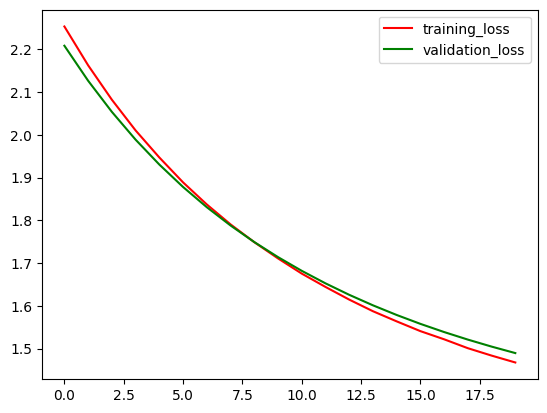

In [86]:
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(val_loss_history, color="g", label="validation_loss")
plt.legend()
plt.show()

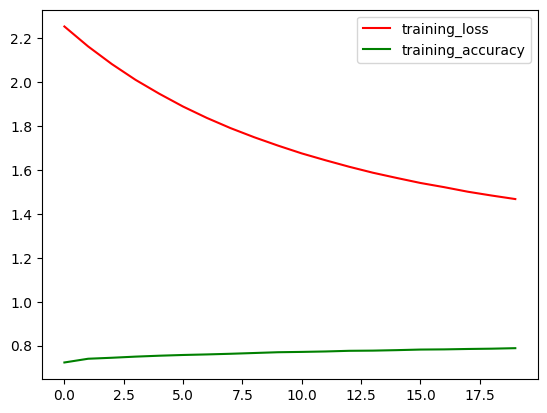

In [87]:
# WRITE CODE HERE
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(train_accuracy_history, color="g", label="training_accuracy")
plt.legend()
plt.show()

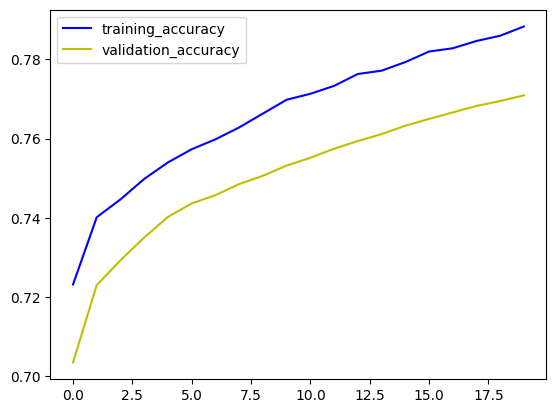

In [88]:
# WRITE CODE HERE

plt.plot(train_accuracy_history, color="b", label="training_accuracy")
plt.plot(val_accuracy_history, color="y", label="validation_accuracy")
plt.legend()
plt.show()



In [89]:
# Evaluate the model on the train & test set after tuning
print("Accuracy on 10% training data:\n")

# Calculate accuracy on the training data
train_accuracy = calculate_accuracy(X_train, y_train, model)
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

# Calculate accuracy on the testing data
test_accuracy = calculate_accuracy(X_test, y_test, model)
print(f'Testing accuracy: {test_accuracy * 100:.2f}%')



Accuracy on 10% training data:

Training accuracy: 78.83%
Testing accuracy: 77.88%


### (b) 20% training data

In [90]:
# Load the data
X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training data into training and validation sets
train_size = int(X_train.shape[0] * 0.2)

X_val = X_train[train_size:]
y_val = y_train[train_size:]

X_train = X_train[:train_size]
y_train = y_train[:train_size]



# Print the shapes of the data sets
print("Train data shape: ", X_train.shape)
print("Label data shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Test data shape: ", X_test.shape)


Train data shape:  (12000, 784)
Label data shape:  (12000,)
Validation data shape:  (48000, 784)
Test data shape:  (10000, 784)


In [91]:

# Create an instance of Single_layer_classifier
input_size = X_train.shape[1]  # 784
num_classes = output_size = 10
model = Single_layer_classifier(input_size, output_size)



In [92]:

# Set hyperparameters

# Learning rate decay
decay_rate = 0.95
learning_rate = 1e-3

lmbda = 1e-3   #regularization coeff
num_epochs = 20
batch_size = 64


In [93]:
# Finally the trainer:
# Make an instance of Single_layer_classifier
# Train for t epochs:
###  Train on the train-set obtained from train-validation split
###  Use the mini-batch generator to get each mini-batch


# Lists to store performance data for plotting
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []


# Training loop
for epoch in tqdm(range(num_epochs)):
    losses = []
    learning_rate *= decay_rate
    for input_x, input_y in get_minibatch(batch_size):
        # Forward pass
        scores = model.forward(input_x)
        
        # Calculate loss and gradient
        loss, dscores = loss_function(input_y, scores, lmbda, model.W)
        losses.append(loss)
        
        # Backward pass
        grad_W, grad_b = model.backward_Ldata(dscores, input_x)
        grad_W += model.backward_Lreg(lmbda)
        
        # Update weights and bias
        model.W -= learning_rate * grad_W
        model.b -= learning_rate * grad_b

    # After each epoch, calculate and print loss and accuracy
    avg_train_loss = np.mean(losses)  # average loss of all batches

    # Calculate validation loss
    val_scores = model.forward(X_val)  # output values
    val_loss, _ = loss_function(y_val, val_scores, lmbda, model.W)  # for entire validation dataset 

    train_acc = calculate_accuracy(X_train, y_train, model)
    val_acc = calculate_accuracy(X_val, y_val, model)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

    # Store loss and accuracy for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 2.2081, Val Loss: 2.1233, Train Accuracy: 71.57%, Val Accuracy: 70.04%
Epoch 2/20, Train Loss: 2.0389, Val Loss: 1.9755, Train Accuracy: 74.03%, Val Accuracy: 72.53%
Epoch 3/20, Train Loss: 1.8987, Val Loss: 1.8520, Train Accuracy: 75.52%, Val Accuracy: 73.86%
Epoch 4/20, Train Loss: 1.7813, Val Loss: 1.7480, Train Accuracy: 76.36%, Val Accuracy: 74.63%
Epoch 5/20, Train Loss: 1.6824, Val Loss: 1.6600, Train Accuracy: 77.11%, Val Accuracy: 75.44%
Epoch 6/20, Train Loss: 1.5990, Val Loss: 1.5849, Train Accuracy: 77.65%, Val Accuracy: 76.06%
Epoch 7/20, Train Loss: 1.5273, Val Loss: 1.5205, Train Accuracy: 78.15%, Val Accuracy: 76.66%
Epoch 8/20, Train Loss: 1.4660, Val Loss: 1.4648, Train Accuracy: 78.72%, Val Accuracy: 77.22%
Epoch 9/20, Train Loss: 1.4123, Val Loss: 1.4164, Train Accuracy: 79.03%, Val Accuracy: 77.66%
Epoch 10/20, Train Loss: 1.3664, Val Loss: 1.3740, Train Accuracy: 79.37%, Val Accuracy: 78.04%
Epoch 11/20, Train Loss: 1.3256, Val Loss: 1.3367

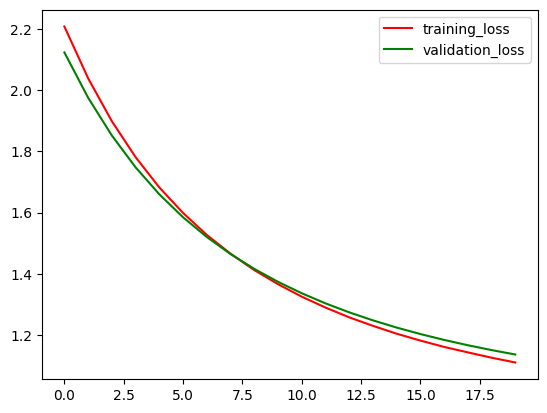

In [94]:
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(val_loss_history, color="g", label="validation_loss")
plt.legend()
plt.show()

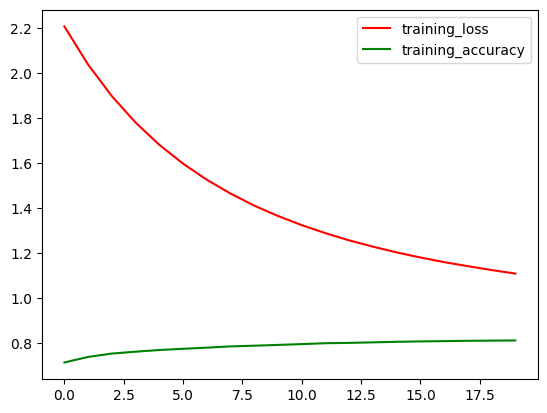

In [95]:
# WRITE CODE HERE
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(train_accuracy_history, color="g", label="training_accuracy")
plt.legend()
plt.show()

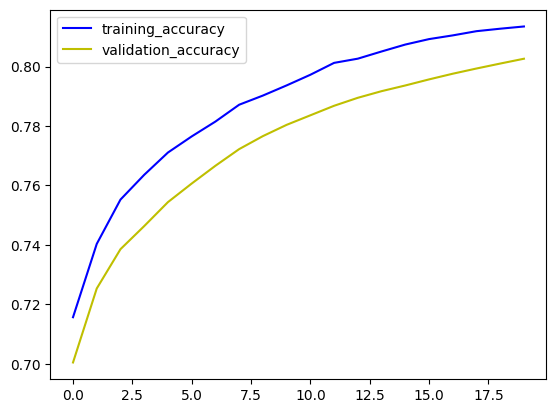

In [96]:
# WRITE CODE HERE

plt.plot(train_accuracy_history, color="b", label="training_accuracy")
plt.plot(val_accuracy_history, color="y", label="validation_accuracy")
plt.legend()
plt.show()



In [97]:
# Evaluate the model on the train & test set after tuning
print("Accuracy on 20% training data:\n")

# Calculate accuracy on the training data
train_accuracy = calculate_accuracy(X_train, y_train, model)
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

# Calculate accuracy on the testing data
test_accuracy = calculate_accuracy(X_test, y_test, model)
print(f'Testing accuracy: {test_accuracy * 100:.2f}%')



Accuracy on 20% training data:

Training accuracy: 81.35%
Testing accuracy: 81.11%


### (c) 50% training data

In [98]:
# Load the data
X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training data into training and validation sets
train_size = int(X_train.shape[0] * 0.8)

X_val = X_train[train_size:]
y_val = y_train[train_size:]

X_train = X_train[:train_size]
y_train = y_train[:train_size]


# Print the shapes of the data sets
print("Train data shape: ", X_train.shape)
print("Label data shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Test data shape: ", X_test.shape)


Train data shape:  (48000, 784)
Label data shape:  (48000,)
Validation data shape:  (12000, 784)
Test data shape:  (10000, 784)


In [99]:

# Create an instance of Single_layer_classifier
input_size = X_train.shape[1]  # 784
num_classes = output_size = 10
model = Single_layer_classifier(input_size, output_size)



In [100]:

# Set hyperparameters

# Learning rate decay
decay_rate = 0.95
learning_rate = 1e-3

lmbda = 1e-3   #regularization coeff
num_epochs = 20
batch_size = 64


In [101]:
# Finally the trainer:
# Make an instance of Single_layer_classifier
# Train for t epochs:
###  Train on the train-set obtained from train-validation split
###  Use the mini-batch generator to get each mini-batch


# Lists to store performance data for plotting
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []


# Training loop
for epoch in tqdm(range(num_epochs)):
    losses = []
    learning_rate *= decay_rate
    for input_x, input_y in get_minibatch(batch_size):
        # Forward pass
        scores = model.forward(input_x)
        
        # Calculate loss and gradient
        loss, dscores = loss_function(input_y, scores, lmbda, model.W)
        losses.append(loss)
        
        # Backward pass
        grad_W, grad_b = model.backward_Ldata(dscores, input_x)
        grad_W += model.backward_Lreg(lmbda)
        
        # Update weights and bias
        model.W -= learning_rate * grad_W
        model.b -= learning_rate * grad_b

    # After each epoch, calculate and print loss and accuracy
    avg_train_loss = np.mean(losses)  # average loss of all batches

    # Calculate validation loss
    val_scores = model.forward(X_val)  # output values
    val_loss, _ = loss_function(y_val, val_scores, lmbda, model.W)  # for entire validation dataset 

    train_acc = calculate_accuracy(X_train, y_train, model)
    val_acc = calculate_accuracy(X_val, y_val, model)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

    # Store loss and accuracy for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.9850, Val Loss: 1.7060, Train Accuracy: 76.02%, Val Accuracy: 77.39%
Epoch 2/20, Train Loss: 1.5436, Val Loss: 1.3698, Train Accuracy: 78.78%, Val Accuracy: 80.73%
Epoch 3/20, Train Loss: 1.2882, Val Loss: 1.1679, Train Accuracy: 80.47%, Val Accuracy: 82.33%
Epoch 4/20, Train Loss: 1.1294, Val Loss: 1.0370, Train Accuracy: 81.64%, Val Accuracy: 83.29%
Epoch 5/20, Train Loss: 1.0231, Val Loss: 0.9464, Train Accuracy: 82.38%, Val Accuracy: 83.97%
Epoch 6/20, Train Loss: 0.9474, Val Loss: 0.8803, Train Accuracy: 83.02%, Val Accuracy: 84.43%
Epoch 7/20, Train Loss: 0.8908, Val Loss: 0.8300, Train Accuracy: 83.44%, Val Accuracy: 84.85%
Epoch 8/20, Train Loss: 0.8471, Val Loss: 0.7906, Train Accuracy: 83.80%, Val Accuracy: 85.24%
Epoch 9/20, Train Loss: 0.8122, Val Loss: 0.7588, Train Accuracy: 84.06%, Val Accuracy: 85.54%
Epoch 10/20, Train Loss: 0.7837, Val Loss: 0.7327, Train Accuracy: 84.34%, Val Accuracy: 85.77%
Epoch 11/20, Train Loss: 0.7600, Val Loss: 0.7110

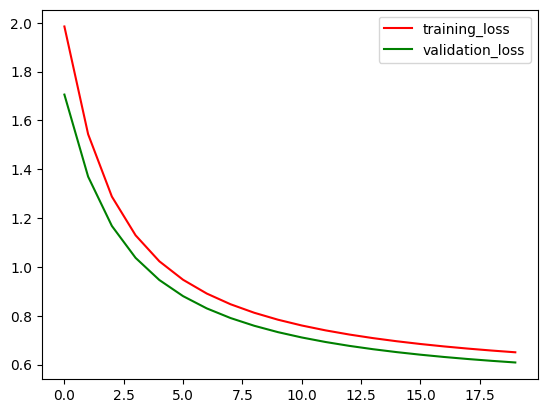

In [102]:
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(val_loss_history, color="g", label="validation_loss")
plt.legend()
plt.show()

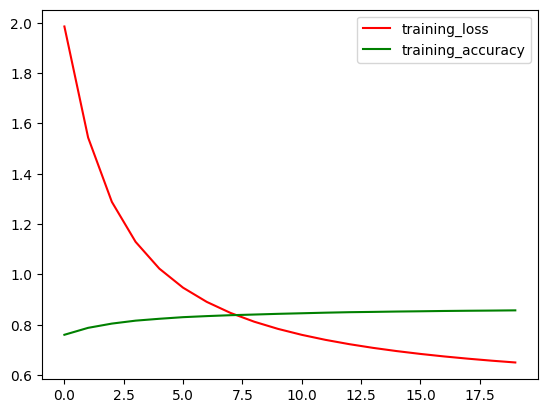

In [103]:
# WRITE CODE HERE
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(train_accuracy_history, color="g", label="training_accuracy")
plt.legend()
plt.show()

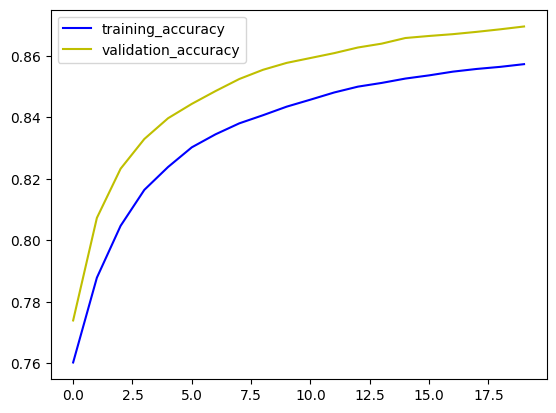

In [104]:
# WRITE CODE HERE

plt.plot(train_accuracy_history, color="b", label="training_accuracy")
plt.plot(val_accuracy_history, color="y", label="validation_accuracy")
plt.legend()
plt.show()



In [105]:
# Evaluate the model on the train & test set after tuning
print("Accuracy on 50% training data:\n")

# Calculate accuracy on the training data
train_accuracy = calculate_accuracy(X_train, y_train, model)
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

# Calculate accuracy on the testing data
test_accuracy = calculate_accuracy(X_test, y_test, model)
print(f'Testing accuracy: {test_accuracy * 100:.2f}%')


Accuracy on 50% training data:

Training accuracy: 85.72%
Testing accuracy: 86.96%


# Training a Linear Classifier on MNIST from scikit-learn

In this section you have to train a linear classifier from the scikit-learn library and compare its results against your implementation.
(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

### Compare the training and test accuracies for the your implementation and linear classifier from scikit-learn

### (a) Logistic Regression

In [119]:
from sklearn.linear_model import LogisticRegression


# Train a Logistic Regression classifier
logistic_clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
logistic_clf.fit(X_train, y_train)

# Calculate accuracy on the training and testing data
train_acc_logistic = accuracy_score(y_train, logistic_clf.predict(X_train))
test_acc_logistic = accuracy_score(y_test, logistic_clf.predict(X_test))

print(f'Training accuracy (Logistic Regression): {train_acc_logistic * 100:.2f}%')
print(f'Testing accuracy (Logistic Regression): {test_acc_logistic * 100:.2f}%')


Training accuracy (Logistic Regression): 93.92%
Testing accuracy (Logistic Regression): 92.50%


### (b) Linear SVM

In [115]:
# SGDClassifier is able to perform multi-class classification by combining multiple binary classifiers in a
# “one versus all” (OvA) scheme. For each of the classes, a binary classifier is learned that discriminates between 
# that and all other classes. At testing time, we compute the confidence score (i.e. the signed distances to the hyperplane) 
# for each classifier and choose the class with the highest confidence.

#This is indeed a multi-class classification problem.



from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Train a linear classifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=best_lambda, max_iter=100, tol=None)
clf.fit(X_train, y_train)

# Calculate accuracy on the training and testing data
train_acc_sklearn = accuracy_score(y_train, clf.predict(X_train))
test_acc_sklearn = accuracy_score(y_test, clf.predict(X_test))

print(f'Training accuracy (Linear SVM): {train_acc_sklearn * 100:.2f}%')
print(f'Testing accuracy (Linear SVM): {test_acc_sklearn * 100:.2f}%')


Training accuracy (Linear SVM): 89.92%
Testing accuracy (Linear SVM): 88.84%


### Any additional observations / comments?

 **Observations**:
1. 1-Layer NN Neural Network Classifier achieves a test accuracy between 85% to 88 % with our implementation.
2. Training on 10%, 20% 50% data, the test accuracy increases, i-e, test accuracy was highest for the model trained with 50% data and lowest for the model trained with 10% data. 
3. The Single 1-Layer NN classifier performs poorly with our implementation compared to Scikit Learn's Logistic regression model but is on-par with Linear SVM model.
4. Hyper parameters {regularization coefficient(lambda), learning_rate} tuning with Grid-search increased the test accuracy by 1-2%.

**Comments:**

For the MNIST image classification task, a 1-layer neural network classifier with cross-entropy loss is expected to perform better than a logistic or ridge regression model of scikit-learn due to its ability to model non-linear relationships between features and labels, and its more appropriate loss function for multi-class classification.
A neural network with even a single hidden layer can model more complex and non-linear relationships between input features and target labels. The MNIST dataset contains 28x28 pixel images, resulting in 784 input features for each sample. A 1-layer neural network with a sufficient number of neurons can learn non-linear combinations of these features, while logistic or ridge regression can only learn linear combinations.

But on Yann lucan website 1-Layer NN classifier has an error rate of 12% which is more than a Logistic regression model of scikit learn which has 8% error rate on test data.

It is true that the performance of different models can vary depending on various factors such as model architecture, hyperparameters, and the specific dataset used for training and testing. Therefore, it is possible that a 1-layer neural network classifier may perform worse than a logistic regression model on the MNIST dataset. For example, our implementation also has an error rate of 12% on test data.

# Implementing Backpropagation

Now that you have had some experience with single layer networks, we can proceed to more complex architectures. But first we need to completely understand and implement backpropagation.

## Backpropagation:

Simply put, a way of computing gradients of expressions through repeated application of chain rule. If
$$
L = f (g (h (\textbf{x})))
$$
then, by the chain rule we have:
$$
\frac{\partial L}{\partial \textbf{x}} = \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial h} \cdot \frac{\partial h}{\partial \textbf{x}} 
$$

** Look into the class Lecture for more detail **



# Question 2 : Scalar Backpropagation

Evaluate the gradient of the following function w.r.t. the input:

$$ f(x,y,z) =  log(\sigma(\frac{cos(\pi \times x)+sin(\pi \times y/2)}{tanh(z^2)}))$$
where $\sigma$ is the sigmoid function. Find gradient for the following inputs:
  * $(x,y,z)$ =  (2,4,1)
  * $(x,y,z)$ =  (9,14,3)
  * $(x,y,z)$ =  (128,42,666)
  * $(x,y,z)$ =  (52,14,28)

      

In [35]:
import numpy as np
import math


In [36]:

class tanh():
    def __init__(self):
        self.f = None

    def forward(self, x):
        self.f = np.tanh(x)
        return self.f

    def backward(self, grad_output):
        return (1 - np.square(self.f)) * grad_output

class log():
    def __init__(self):
        self.f = None
        self.x = None

    def forward(self, x):
        self.f = np.log(x)
        self.x = x
        return self.f

    def backward(self, grad_output):
        return (1 / self.x) * grad_output

class Sigmoid():
    def __init__(self):
        self.f = None

    def forward(self, x):
        self.f = 1 / (1 + np.exp(-x))
        return self.f

    def backward(self, grad_output):
        return self.f * (1 - self.f) * grad_output


class Func():
    def __init__(self):
        self.x = None
        self.y = None
        self.z = None
        self.a = None
        self.b = None
        self.c = None
        self.d = None
        self.e = None
        self.f = None
        self.g = None
        self.h = None
        self.i = None
        self.j = None

    def forward(self, x, y, z):
        self.x, self.y, self.z = x, y, z

        self.a = math.pi * self.x
        self.b = math.pi * self.y / 2
        self.c = np.square(self.z)
        self.d = np.cos(self.a)
        self.e = np.sin(self.b)
        self.f = self.d + self.e
        self.g = np.tanh(self.c)
        self.h = np.divide(self.f, self.g)
        self.i = 1 / (1 + np.exp(-self.h))
        self.j = np.log(self.i)
        return self.j

    def backward(self, grad_output):
        out = 1 / self.i
        out *= self.i * (1 - self.i)
        grad_xy = out * (1 / self.g)

        grad_x = (-1) * np.pi * np.sin(self.a) * grad_xy

        grad_y = (np.pi / 2) * np.cos(self.b) * grad_xy

        grad_z = -out * self.f * (1 / np.square(self.g))
        grad_z = grad_z * (1 - np.square(self.g))
        grad_z = 2 * self.z * grad_z

        return np.array([grad_x, grad_y, grad_z])




In [37]:

func = Func()

inputs = [(2, 4, 1), (9, 14, 3), (128, 42, 666), (52, 14, 28)]

for input_ in inputs:
    x, y, z = input_
    print(f"Inputs: ({x}, {y}, {z})")
    output = func.forward(x, y, z)
    grads = func.backward(1)
    print(f"Output (forward pass): {output}")
    print(f"Gradients (backward pass): ({grads[0]}, {grads[1]}, {grads[2]})")
    print()


Inputs: (2, 4, 1)
Output (forward pass): -0.23823101469115085
Gradients (backward pass): (2.1417102890343505e-16, 0.43720979194276516, -0.3069722756588883)

Inputs: (9, 14, 3)
Output (forward pass): -1.3132617097862374
Gradients (backward pass): (-2.5313688314302287e-15, -1.148344174369598, 2.672161875217988e-07)

Inputs: (128, 42, 666)
Output (forward pass): -0.31326168751822314
Gradients (backward pass): (1.3244281103803983e-14, -0.42245219681098717, -0.0)

Inputs: (52, 14, 28)
Output (forward pass): -0.31326168751822253
Gradients (backward pass): (-6.6263243875773434e-15, -0.42245219681098645, -0.0)



In [32]:
# verify/check

import numpy as np
from scipy.special import expit
from numdifftools import Gradient

def func(x):
    a = np.cos(np.pi*x[0]) + np.sin(np.pi*x[1]/2)
    b = np.tanh(x[2]**2)
    return np.log(expit(a/b))

inputs = np.array([[2, 4, 1], [9, 14, 3], [128, 42, 666], [52, 14, 28]])

for i in inputs:
    grad = Gradient(func)(i)
    print(f"Gradient for {i}: {grad}")


Gradient for [2 4 1]: [ 0.          0.43720979 -0.30697228]
Gradient for [ 9 14  3]: [ 0.00000000e+00 -1.14834417e+00  2.67216166e-07]
Gradient for [128  42 666]: [ 3.30306832e-15 -4.22452197e-01  0.00000000e+00]
Gradient for [52 14 28]: [ 4.66610457e-15 -4.22452197e-01  0.00000000e+00]


## Question 3 : Modular Vector Backpropagation

* Construct a Linear Layer module, implementing the forward and backward functions for arbitrary sizes.
* Construct a ReLU module, implementing the forward and backward functions for arbitrary sizes.
* Create a 2 layer MLP using the constructed modules.

* Modifying the functions built in Question 1 , train this two layer MLP for the same data set, MNIST, with the same train-val split.

In [14]:
# Load the data
X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training data into training and validation sets
train_size = int(X_train.shape[0] * 0.8)

X_val = X_train[train_size:]
y_val = y_train[train_size:]

X_train = X_train[:train_size]
y_train = y_train[:train_size]

In [15]:

# Print the shapes of the data sets
print("Train data shape: ", X_train.shape)
print("Label data shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Test data shape: ", X_test.shape)


Train data shape:  (48000, 784)
Label data shape:  (48000,)
Validation data shape:  (12000, 784)
Test data shape:  (10000, 784)


In [16]:
# Class for ReLU
class ReLU:
    def forward(self, X):
        self.X = X
        return np.maximum(0, X)

    def backward(self, dout):
        return dout * (self.X > 0)

    
# Class for Linear Layer
class LinearLayer:
    def __init__(self, input_size, output_size):
        self.W = np.random.normal(0, 1e-3, (input_size, output_size)) 
        self.b = np.zeros((1, output_size))

    def forward(self, X):
        self.X = X
        return np.dot(X, self.W) + self.b

    def backward(self, dout):
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout)
        self.db = np.sum(dout, axis=0)
        return dX

    
# Your 2 layer MLP 
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.fc1 = LinearLayer(input_size, hidden_size)
        self.relu = ReLU()
        self.fc2 = LinearLayer(hidden_size, output_size)

    def forward(self, X):
        self.a1 = self.fc1.forward(X)
        self.h1 = self.relu.forward(self.a1)
        self.a2 = self.fc2.forward(self.h1)
        return self.a2

    def backward(self, dout):
        dout = self.fc2.backward(dout)
        dout = self.relu.backward(dout)
        dout = self.fc1.backward(dout)
        return dout



In [17]:
def softmax(scores):
    scores -= np.max(scores)
    probabilities = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
    return probabilities

def loss_function(input_y, scores, lmbda, W):
    num_examples = scores.shape[0]
    probabilities = softmax(scores)
    
    corect_logprobs = -np.log(probabilities[range(num_examples),input_y])
    data_loss = np.sum(corect_logprobs) / num_examples
    reg_loss = 0.5 * lmbda * sum(np.sum(Wi**2) for Wi in W)
    loss = data_loss + reg_loss
    
    dscores = probabilities
    dscores[range(num_examples),input_y] -= 1
    dscores /= num_examples
    
    return loss, dscores


In [18]:

# Create an instance of Single_layer_classifier
input_size = X_train.shape[1]  # 784
num_classes = output_size = 10

hidden_size = 128

# instantiate the model
model = MLP(input_size, hidden_size, num_classes)


In [69]:

# Set hyperparameters

# Learning rate 
learning_rate = 1e-3

lmbda = 1e-3   #regularization coeff
num_epochs = 1000
batch_size = 64




In [70]:

# Training loop

# Lists to store performance data for plotting
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in tqdm(range(num_epochs)):
    losses = []
    #learning_rate *= decay_rate
    for input_x, input_y in get_minibatch(batch_size):
        # Forward pass
        scores = model.forward(input_x)
        
        # Calculate loss and gradient
        loss, dscores = loss_function(input_y, scores, lmbda, [model.fc1.W, model.fc2.W])
        losses.append(loss)
        
        # Backward pass
        model.backward(dscores)
        
        # Update weights and bias
        model.fc1.W -= learning_rate * model.fc1.dW
        model.fc1.b -= learning_rate * model.fc1.db
        model.fc2.W -= learning_rate * model.fc2.dW
        model.fc2.b -= learning_rate * model.fc2.db

    # After each epoch, calculate and print loss and accuracy
    avg_train_loss = np.mean(losses)  # average loss of all batches

    # Calculate validation loss
    val_scores = model.forward(X_val)  # output values
    val_loss, _ = loss_function(y_val, val_scores, lmbda, [model.fc1.W, model.fc2.W])  # for entire validation dataset 

    train_acc = calculate_accuracy(X_train, y_train, model)
    val_acc = calculate_accuracy(X_val, y_val, model)

    if(epoch % 10 == 0 or epoch == 499 or epoch == 999):
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

    # Store loss and accuracy for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000, Train Loss: 2.3025, Val Loss: 2.3024, Train Accuracy: 11.40%, Val Accuracy: 10.60%
Epoch 11/1000, Train Loss: 2.2285, Val Loss: 2.2030, Train Accuracy: 29.28%, Val Accuracy: 29.01%
Epoch 21/1000, Train Loss: 1.0937, Val Loss: 1.0346, Train Accuracy: 71.35%, Val Accuracy: 73.24%
Epoch 31/1000, Train Loss: 0.6644, Val Loss: 0.6249, Train Accuracy: 82.36%, Val Accuracy: 83.93%
Epoch 41/1000, Train Loss: 0.5220, Val Loss: 0.4909, Train Accuracy: 86.28%, Val Accuracy: 87.31%
Epoch 51/1000, Train Loss: 0.4577, Val Loss: 0.4313, Train Accuracy: 87.97%, Val Accuracy: 88.78%
Epoch 61/1000, Train Loss: 0.4213, Val Loss: 0.3981, Train Accuracy: 88.89%, Val Accuracy: 89.68%
Epoch 71/1000, Train Loss: 0.3973, Val Loss: 0.3759, Train Accuracy: 89.55%, Val Accuracy: 90.21%
Epoch 81/1000, Train Loss: 0.3796, Val Loss: 0.3594, Train Accuracy: 90.05%, Val Accuracy: 90.66%
Epoch 91/1000, Train Loss: 0.3653, Val Loss: 0.3465, Train Accuracy: 90.38%, Val Accuracy: 90.97%
Epoch 101/1000, Train

Epoch 821/1000, Train Loss: 0.1785, Val Loss: 0.2039, Train Accuracy: 97.60%, Val Accuracy: 96.78%
Epoch 831/1000, Train Loss: 0.1783, Val Loss: 0.2040, Train Accuracy: 97.62%, Val Accuracy: 96.80%
Epoch 841/1000, Train Loss: 0.1781, Val Loss: 0.2041, Train Accuracy: 97.65%, Val Accuracy: 96.80%
Epoch 851/1000, Train Loss: 0.1779, Val Loss: 0.2043, Train Accuracy: 97.69%, Val Accuracy: 96.82%
Epoch 861/1000, Train Loss: 0.1777, Val Loss: 0.2044, Train Accuracy: 97.72%, Val Accuracy: 96.82%
Epoch 871/1000, Train Loss: 0.1775, Val Loss: 0.2046, Train Accuracy: 97.75%, Val Accuracy: 96.84%
Epoch 881/1000, Train Loss: 0.1773, Val Loss: 0.2048, Train Accuracy: 97.78%, Val Accuracy: 96.84%
Epoch 891/1000, Train Loss: 0.1772, Val Loss: 0.2049, Train Accuracy: 97.82%, Val Accuracy: 96.83%
Epoch 901/1000, Train Loss: 0.1770, Val Loss: 0.2051, Train Accuracy: 97.85%, Val Accuracy: 96.88%
Epoch 911/1000, Train Loss: 0.1769, Val Loss: 0.2053, Train Accuracy: 97.87%, Val Accuracy: 96.88%
Epoch 921/

### Plot the training loss and validation loss

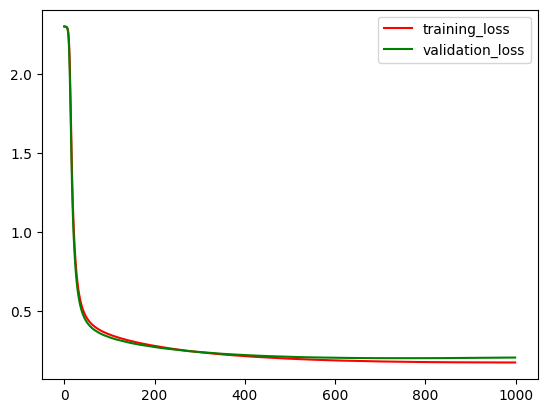

In [71]:
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(val_loss_history, color="g", label="validation_loss")
plt.legend()
plt.show()

### Plotting training loss vs training accuracy.

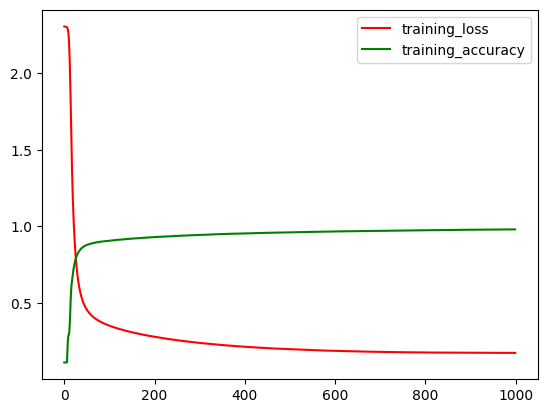

In [72]:
# WRITE CODE HERE
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(train_accuracy_history, color="g", label="training_accuracy")
plt.legend()
plt.show()

### Find the accuracy on the validation set


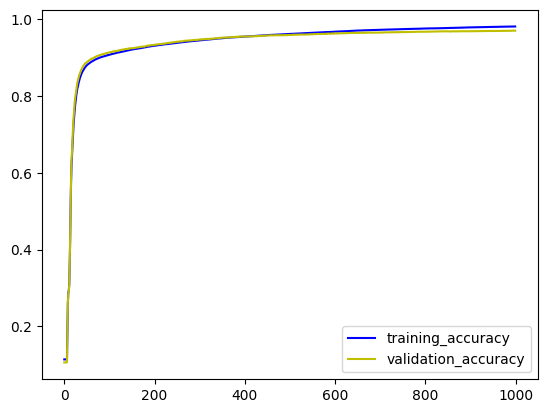

In [73]:
# WRITE CODE HERE

plt.plot(train_accuracy_history, color="b", label="training_accuracy")
plt.plot(val_accuracy_history, color="y", label="validation_accuracy")
plt.legend()
plt.show()



### Accuracy of the model on train and test data.

In [74]:
# Calculate accuracy on the training data
train_accuracy = calculate_accuracy(X_train, y_train, model)
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

# Calculate accuracy on the testing data
test_accuracy = calculate_accuracy(X_test, y_test, model)
print(f'Testing accuracy: {test_accuracy * 100:.2f}%')


Training accuracy: 98.09%
Testing accuracy: 97.18%


## GridSearch:
### Tuning 2 Hyper parameters lambda (regularization coefficient) and learning rate (with num_epochs = 100).

In [140]:
# Define the hyperparameters to search over
learning_rates = [1e-3, 1e-4, 1e-5]
regularization_strengths = [1e-3, 1e-4, 1e-5]

# Initialize variables to store the best model and the highest validation accuracy
best_model = None
best_val_accuracy = -1

num_epochs = 100

# Grid search over the hyperparameters
for lr in learning_rates:
    for lmbda in regularization_strengths:
        # Train a model with the current hyperparameters
        model = MLP(input_size, hidden_size, num_classes)  # instantiate
        for epoch in tqdm(range(num_epochs)):
            for input_x, input_y in get_minibatch(batch_size):
                # Forward pass
                scores = model.forward(input_x)
                
                # Calculate loss and gradient
                loss, dscores = loss_function(input_y, scores, lmbda, [model.fc1.W, model.fc2.W])
                
                # Backward pass
                model.backward(dscores)
                
                # Update weights and bias
                model.fc1.W -= lr * model.fc1.dW
                model.fc1.b -= lr * model.fc1.db
                model.fc2.W -= lr * model.fc2.dW
                model.fc2.b -= lr * model.fc2.db
        
        # Evaluate the model on the validation set
        val_acc = calculate_accuracy(X_val, y_val, model)
        
        # If the model is better than the best model so far, store it
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model = model
            best_learning_rate = lr
            best_lambda = lmbda
        
        print(f"Learning rate: {lr}, Regularization coefficient: {lmbda}, Validation accuracy: {val_acc}")
        
print(f"\nBest lambda: {best_lambda}, Best learning rate: {best_learning_rate}, Best validation accuracy: {best_val_accuracy}")


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate: 0.001, Regularization coefficient: 0.001, Validation accuracy: 0.9129166666666667


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate: 0.001, Regularization coefficient: 0.0001, Validation accuracy: 0.91175


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate: 0.001, Regularization coefficient: 1e-05, Validation accuracy: 0.913


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate: 0.0001, Regularization coefficient: 0.001, Validation accuracy: 0.24841666666666667


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate: 0.0001, Regularization coefficient: 0.0001, Validation accuracy: 0.24683333333333332


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate: 0.0001, Regularization coefficient: 1e-05, Validation accuracy: 0.2649166666666667


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate: 1e-05, Regularization coefficient: 0.001, Validation accuracy: 0.106


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate: 1e-05, Regularization coefficient: 0.0001, Validation accuracy: 0.106


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate: 1e-05, Regularization coefficient: 1e-05, Validation accuracy: 0.106

Best lambda: 1e-05, Best learning rate: 0.001, Best validation accuracy: 0.913


### Train with best (optimal) hyperparameters

In [19]:

# Set optimal (best) hyperparameters

# optimal Learning rate 
learning_rate = best_learning_rate
# optimal regularization coeff
lmbda = best_lambda  

num_epochs = 1000
batch_size = 64


# instantiate the model
model = MLP(input_size, hidden_size, num_classes)


In [144]:

# Training loop

# Lists to store performance data for plotting
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in tqdm(range(num_epochs)):
    losses = []
    #learning_rate *= decay_rate
    for input_x, input_y in get_minibatch(batch_size):
        # Forward pass
        scores = model.forward(input_x)
        
        # Calculate loss and gradient
        loss, dscores = loss_function(input_y, scores, lmbda, [model.fc1.W, model.fc2.W])
        losses.append(loss)
        
        # Backward pass
        model.backward(dscores)
        
        # Update weights and bias
        model.fc1.W -= learning_rate * model.fc1.dW
        model.fc1.b -= learning_rate * model.fc1.db
        model.fc2.W -= learning_rate * model.fc2.dW
        model.fc2.b -= learning_rate * model.fc2.db

    # After each epoch, calculate and print loss and accuracy
    avg_train_loss = np.mean(losses)  # average loss of all batches

    # Calculate validation loss
    val_scores = model.forward(X_val)  # output values
    val_loss, _ = loss_function(y_val, val_scores, lmbda, [model.fc1.W, model.fc2.W])  # for entire validation dataset 

    train_acc = calculate_accuracy(X_train, y_train, model)
    val_acc = calculate_accuracy(X_val, y_val, model)

    if(epoch % 10 == 0 or epoch == 499):
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

    # Store loss and accuracy for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)
    
    

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500, Train Loss: 2.3024, Val Loss: 2.3023, Train Accuracy: 11.40%, Val Accuracy: 10.60%
Epoch 11/500, Train Loss: 2.1971, Val Loss: 2.1644, Train Accuracy: 28.59%, Val Accuracy: 28.52%
Epoch 21/500, Train Loss: 1.0196, Val Loss: 0.9613, Train Accuracy: 73.11%, Val Accuracy: 74.88%
Epoch 31/500, Train Loss: 0.6316, Val Loss: 0.5920, Train Accuracy: 83.23%, Val Accuracy: 84.39%
Epoch 41/500, Train Loss: 0.4977, Val Loss: 0.4665, Train Accuracy: 86.58%, Val Accuracy: 87.52%
Epoch 51/500, Train Loss: 0.4351, Val Loss: 0.4087, Train Accuracy: 88.08%, Val Accuracy: 88.87%
Epoch 61/500, Train Loss: 0.3987, Val Loss: 0.3752, Train Accuracy: 88.90%, Val Accuracy: 89.72%
Epoch 71/500, Train Loss: 0.3740, Val Loss: 0.3523, Train Accuracy: 89.56%, Val Accuracy: 90.20%
Epoch 81/500, Train Loss: 0.3555, Val Loss: 0.3352, Train Accuracy: 90.06%, Val Accuracy: 90.61%
Epoch 91/500, Train Loss: 0.3406, Val Loss: 0.3215, Train Accuracy: 90.36%, Val Accuracy: 90.91%
Epoch 101/500, Train Loss: 0.32

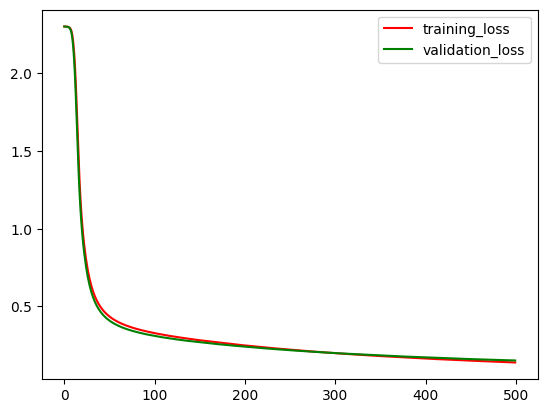

In [145]:
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(val_loss_history, color="g", label="validation_loss")
plt.legend()
plt.show()

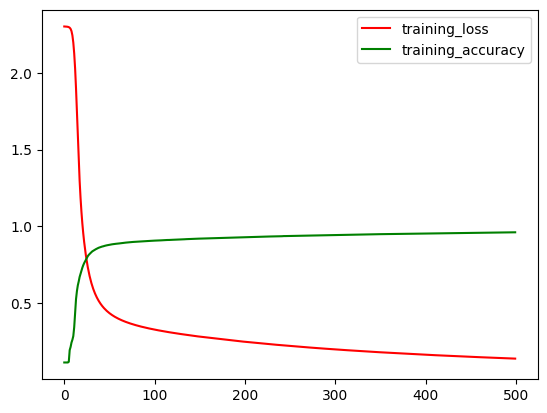

In [146]:
# WRITE CODE HERE
plt.plot(train_loss_history, color="r", label="training_loss")
plt.plot(train_accuracy_history, color="g", label="training_accuracy")
plt.legend()
plt.show()

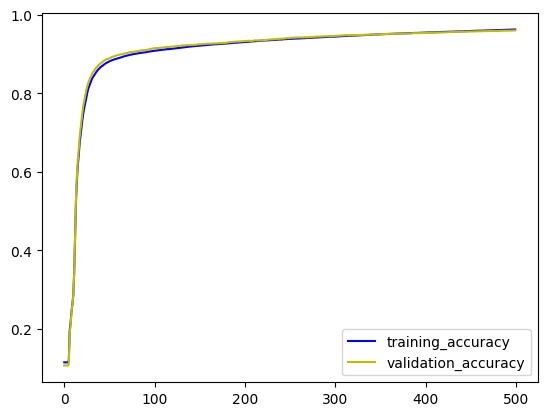

In [147]:
# WRITE CODE HERE

plt.plot(train_accuracy_history, color="b", label="training_accuracy")
plt.plot(val_accuracy_history, color="y", label="validation_accuracy")
plt.legend()
plt.show()



### Report final performance on MNIST test set

In [152]:
print("After hyper parameters tuning:\n")  # for 500 epochs only

best_model = model


# Calculate accuracy on the training data
train_accuracy = calculate_accuracy(X_train, y_train, best_model)
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

# Calculate accuracy on the testing data
test_accuracy = calculate_accuracy(X_test, y_test, best_model)
print(f'Testing accuracy: {test_accuracy * 100:.2f}%')


After hyper parameters tuning:

Training accuracy: 96.19%
Testing accuracy: 95.69%


#### NOTE: 
We have trained till 500 epochs only with optimal hyperparameters due to time contraint. Performance might improve further and attain a test accuracy of 98% if trained for 1000 epochs.

### Find the best performing class and the worst performing class

In [153]:
# Calculate confusion matrix
y_pred = np.argmax(best_model.forward(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

# Calculate class-wise accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Find best and worst classes
best_class = np.argmax(class_accuracy)
worst_class = np.argmin(class_accuracy)

print(f"Best performing class: {best_class}, accuracy: {class_accuracy[best_class] * 100:.2f}%")
print(f"Worst performing class: {worst_class}, accuracy: {class_accuracy[worst_class] * 100:.2f}%")

Best performing class: 0, accuracy: 98.27%
Worst performing class: 5, accuracy: 93.39%


### Any additional observations / comments?

# Observations:
### 1. 2-Layer Neural Network Classifier(MLP) achieves a test accuracy more than 97%.
### 2. Training on 10%, 20% 50% data, the test accuracy increases with the percentage of data, i-e, test accuracy was highest for the model trained with 50% data and lowest for the model trained with 10% data. 
### 3. 2-Layer Neural Network classifier(MLP) performs better(upto +9% test accuracy) compared to 1-Layer Neural Network & Scikit-Learn's Linear SVM model and (upto +5% test accuracy) compared to the Logistic regression model with our implementation.
### 4. Hyper parameters {regularization coefficient, learning_rate} tuning with Grid-search merely increased the test accuracy by 0.04% when compared with 500 epochs but might increase by 1% if trained for 1000 epochs with optimal hyperparameters.

## Comments:

In general, a 2-layer neural network with ReLU activation and cross-entropy loss could potentially outperform logistic regression or linear SVM for MNIST image classification.

This is because a neural network is a more complex model that can learn more complex and non-linear patterns in the data, while logistic regression or linear SVM is a linear model. In addition, the ReLU activation function allows the neural network to learn more efficiently by reducing the vanishing gradient problem.


However, the performance of either model ultimately depends on several factors, including the size and quality of the data, the choice of hyperparameters, and the implementation of the models. 

With more training data, the model is exposed to a greater variety of patterns and can learn more robust features to better distinguish between different classes. However, it's important to note that there may be a point of diminishing returns, where adding more data does not lead to significant improvements in accuracy. For example, in Question-1, the test accuracy of 1-Layer NN model after training on 50% data did not show any great improvement (test accuracy only improved by 1-2%) compared to model trained on 80% training data.

## BONUS Question
### Observe the effect on test set accuracy by changing the number of training samples.
### Train on 10%, 20% and 50% training data and plot the percentage of training data v.s. the test accuracy.  

### (a) 10% training data

In [29]:
# Load the data
X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training data into training and validation sets
train_size = int(X_train.shape[0] * 0.1)

X_val = X_train[train_size:]
y_val = y_train[train_size:]

X_train = X_train[:train_size]
y_train = y_train[:train_size]


# Print the shapes of the data sets
print("Train data shape: ", X_train.shape)
print("Label data shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Test data shape: ", X_test.shape)


Train data shape:  (6000, 784)
Label data shape:  (6000,)
Validation data shape:  (54000, 784)
Test data shape:  (10000, 784)


In [30]:

# Create an instance of Single_layer_classifier
input_size = X_train.shape[1]  # 784
num_classes = output_size = 10

hidden_size = 128

# instantiate the model
model = MLP(input_size, hidden_size, num_classes)


In [31]:

# Set optimal (best) hyperparameters

# optimal Learning rate 
learning_rate = best_learning_rate

# optimal regularization coeff
lmbda = best_lambda  
num_epochs = 500
batch_size = 64




In [32]:

# Training loop

# Lists to store performance data for plotting
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in tqdm(range(num_epochs)):
    losses = []
    #learning_rate *= decay_rate
    for input_x, input_y in get_minibatch(batch_size):
        # Forward pass
        scores = model.forward(input_x)
        
        # Calculate loss and gradient
        loss, dscores = loss_function(input_y, scores, lmbda, [model.fc1.W, model.fc2.W])
        losses.append(loss)
        
        # Backward pass
        model.backward(dscores)
        
        # Update weights and bias
        model.fc1.W -= learning_rate * model.fc1.dW
        model.fc1.b -= learning_rate * model.fc1.db
        model.fc2.W -= learning_rate * model.fc2.dW
        model.fc2.b -= learning_rate * model.fc2.db

    # After each epoch, calculate and print loss and accuracy
    avg_train_loss = np.mean(losses)  # average loss of all batches

    # Calculate validation loss
    val_scores = model.forward(X_val)  # output values
    val_loss, _ = loss_function(y_val, val_scores, lmbda, [model.fc1.W, model.fc2.W])  # for entire validation dataset 

    train_acc = calculate_accuracy(X_train, y_train, model)
    val_acc = calculate_accuracy(X_val, y_val, model)

    if(epoch % 10 == 0 or epoch == 499):
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

    # Store loss and accuracy for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500, Train Loss: 2.3026, Val Loss: 2.3025, Train Accuracy: 11.18%, Val Accuracy: 11.24%
Epoch 11/500, Train Loss: 2.3020, Val Loss: 2.3021, Train Accuracy: 11.18%, Val Accuracy: 11.24%
Epoch 21/500, Train Loss: 2.3014, Val Loss: 2.3017, Train Accuracy: 11.18%, Val Accuracy: 11.24%
Epoch 31/500, Train Loss: 2.3005, Val Loss: 2.3010, Train Accuracy: 11.18%, Val Accuracy: 11.24%
Epoch 41/500, Train Loss: 2.2989, Val Loss: 2.2995, Train Accuracy: 11.18%, Val Accuracy: 11.24%
Epoch 51/500, Train Loss: 2.2953, Val Loss: 2.2961, Train Accuracy: 18.78%, Val Accuracy: 17.74%
Epoch 61/500, Train Loss: 2.2871, Val Loss: 2.2879, Train Accuracy: 30.05%, Val Accuracy: 29.45%
Epoch 71/500, Train Loss: 2.2675, Val Loss: 2.2682, Train Accuracy: 30.88%, Val Accuracy: 30.89%
Epoch 81/500, Train Loss: 2.2242, Val Loss: 2.2248, Train Accuracy: 30.57%, Val Accuracy: 30.57%
Epoch 91/500, Train Loss: 2.1428, Val Loss: 2.1441, Train Accuracy: 33.55%, Val Accuracy: 33.31%
Epoch 101/500, Train Loss: 2.01

In [33]:
# Calculate accuracy on the training data

print("Accuracy on 10% training data:\n")

train_accuracy = calculate_accuracy(X_train, y_train, model)
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

# Calculate accuracy on the testing data
test_accuracy = calculate_accuracy(X_test, y_test, model)
print(f'Testing accuracy: {test_accuracy * 100:.2f}%')


Accuracy on 10% training data:

Training accuracy: 90.77%
Testing accuracy: 88.96%


### (b) 20% training data

In [34]:
# Load the data
X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training data into training and validation sets
train_size = int(X_train.shape[0] * 0.2)

X_val = X_train[train_size:]
y_val = y_train[train_size:]

X_train = X_train[:train_size]
y_train = y_train[:train_size]


# Print the shapes of the data sets
print("Train data shape: ", X_train.shape)
print("Label data shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Test data shape: ", X_test.shape)


Train data shape:  (12000, 784)
Label data shape:  (12000,)
Validation data shape:  (48000, 784)
Test data shape:  (10000, 784)


In [35]:

# Create an instance of Single_layer_classifier
input_size = X_train.shape[1]  # 784
num_classes = output_size = 10

hidden_size = 128

# instantiate the model
model = MLP(input_size, hidden_size, num_classes)


In [36]:

# Set optimal (best) hyperparameters

# optimal Learning rate 
learning_rate = best_learning_rate

# optimal regularization coeff
lmbda = best_lambda  
num_epochs = 500
batch_size = 64




In [37]:

# Training loop

# Lists to store performance data for plotting
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in tqdm(range(num_epochs)):
    losses = []
    #learning_rate *= decay_rate
    for input_x, input_y in get_minibatch(batch_size):
        # Forward pass
        scores = model.forward(input_x)
        
        # Calculate loss and gradient
        loss, dscores = loss_function(input_y, scores, lmbda, [model.fc1.W, model.fc2.W])
        losses.append(loss)
        
        # Backward pass
        model.backward(dscores)
        
        # Update weights and bias
        model.fc1.W -= learning_rate * model.fc1.dW
        model.fc1.b -= learning_rate * model.fc1.db
        model.fc2.W -= learning_rate * model.fc2.dW
        model.fc2.b -= learning_rate * model.fc2.db

    # After each epoch, calculate and print loss and accuracy
    avg_train_loss = np.mean(losses)  # average loss of all batches

    # Calculate validation loss
    val_scores = model.forward(X_val)  # output values
    val_loss, _ = loss_function(y_val, val_scores, lmbda, [model.fc1.W, model.fc2.W])  # for entire validation dataset 

    train_acc = calculate_accuracy(X_train, y_train, model)
    val_acc = calculate_accuracy(X_val, y_val, model)

    if(epoch % 10 == 0 or epoch == 499):
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

    # Store loss and accuracy for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500, Train Loss: 2.3025, Val Loss: 2.3025, Train Accuracy: 11.26%, Val Accuracy: 11.23%
Epoch 11/500, Train Loss: 2.3016, Val Loss: 2.3017, Train Accuracy: 11.26%, Val Accuracy: 11.23%
Epoch 21/500, Train Loss: 2.2994, Val Loss: 2.2996, Train Accuracy: 11.26%, Val Accuracy: 11.23%
Epoch 31/500, Train Loss: 2.2886, Val Loss: 2.2885, Train Accuracy: 27.88%, Val Accuracy: 27.52%
Epoch 41/500, Train Loss: 2.2304, Val Loss: 2.2287, Train Accuracy: 27.13%, Val Accuracy: 26.76%
Epoch 51/500, Train Loss: 2.0488, Val Loss: 2.0463, Train Accuracy: 34.26%, Val Accuracy: 33.60%
Epoch 61/500, Train Loss: 1.6917, Val Loss: 1.6899, Train Accuracy: 51.32%, Val Accuracy: 50.28%
Epoch 71/500, Train Loss: 1.3046, Val Loss: 1.3116, Train Accuracy: 63.04%, Val Accuracy: 62.42%
Epoch 81/500, Train Loss: 1.0495, Val Loss: 1.0621, Train Accuracy: 71.16%, Val Accuracy: 70.23%
Epoch 91/500, Train Loss: 0.8864, Val Loss: 0.9012, Train Accuracy: 76.02%, Val Accuracy: 75.19%
Epoch 101/500, Train Loss: 0.77

In [38]:
# Calculate accuracy on the training data

print("Accuracy on 20% training data:\n")

train_accuracy = calculate_accuracy(X_train, y_train, model)
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

# Calculate accuracy on the testing data
test_accuracy = calculate_accuracy(X_test, y_test, model)
print(f'Testing accuracy: {test_accuracy * 100:.2f}%')


Accuracy on 20% training data:

Training accuracy: 92.81%
Testing accuracy: 91.24%


### (c) 50% training data

In [39]:
# Load the data
X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training data into training and validation sets
train_size = int(X_train.shape[0] * 0.5)

X_val = X_train[train_size:]
y_val = y_train[train_size:]

X_train = X_train[:train_size]
y_train = y_train[:train_size]


# Print the shapes of the data sets
print("Train data shape: ", X_train.shape)
print("Label data shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Test data shape: ", X_test.shape)


Train data shape:  (30000, 784)
Label data shape:  (30000,)
Validation data shape:  (30000, 784)
Test data shape:  (10000, 784)


In [40]:

# Create an instance of Single_layer_classifier
input_size = X_train.shape[1]  # 784
num_classes = output_size = 10

hidden_size = 128

# instantiate the model
model = MLP(input_size, hidden_size, num_classes)


In [41]:

# Set optimal (best) hyperparameters

# Learning rate 
best_learning_rate = 0.001
learning_rate = best_learning_rate

best_lambda = 1e-5
lmbda = best_lambda   #regularization coeff
num_epochs = 500
batch_size = 64




In [42]:

# Training loop

# Lists to store performance data for plotting
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in tqdm(range(num_epochs)):
    losses = []
    #learning_rate *= decay_rate
    for input_x, input_y in get_minibatch(batch_size):
        # Forward pass
        scores = model.forward(input_x)
        
        # Calculate loss and gradient
        loss, dscores = loss_function(input_y, scores, lmbda, [model.fc1.W, model.fc2.W])
        losses.append(loss)
        
        # Backward pass
        model.backward(dscores)
        
        # Update weights and bias
        model.fc1.W -= learning_rate * model.fc1.dW
        model.fc1.b -= learning_rate * model.fc1.db
        model.fc2.W -= learning_rate * model.fc2.dW
        model.fc2.b -= learning_rate * model.fc2.db

    # After each epoch, calculate and print loss and accuracy
    avg_train_loss = np.mean(losses)  # average loss of all batches

    # Calculate validation loss
    val_scores = model.forward(X_val)  # output values
    val_loss, _ = loss_function(y_val, val_scores, lmbda, [model.fc1.W, model.fc2.W])  # for entire validation dataset 

    train_acc = calculate_accuracy(X_train, y_train, model)
    val_acc = calculate_accuracy(X_val, y_val, model)

    if(epoch % 10 == 0 or epoch == 499):
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

    # Store loss and accuracy for plotting
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_acc)
    val_accuracy_history.append(val_acc)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500, Train Loss: 2.3025, Val Loss: 2.3024, Train Accuracy: 11.41%, Val Accuracy: 11.06%
Epoch 11/500, Train Loss: 2.2965, Val Loss: 2.2955, Train Accuracy: 12.58%, Val Accuracy: 11.98%
Epoch 21/500, Train Loss: 2.0619, Val Loss: 2.0326, Train Accuracy: 37.32%, Val Accuracy: 36.89%
Epoch 31/500, Train Loss: 1.1827, Val Loss: 1.1552, Train Accuracy: 69.01%, Val Accuracy: 69.61%
Epoch 41/500, Train Loss: 0.7868, Val Loss: 0.7743, Train Accuracy: 79.08%, Val Accuracy: 79.55%
Epoch 51/500, Train Loss: 0.6130, Val Loss: 0.6077, Train Accuracy: 83.69%, Val Accuracy: 83.67%
Epoch 61/500, Train Loss: 0.5229, Val Loss: 0.5216, Train Accuracy: 86.06%, Val Accuracy: 85.77%
Epoch 71/500, Train Loss: 0.4685, Val Loss: 0.4697, Train Accuracy: 87.34%, Val Accuracy: 87.15%
Epoch 81/500, Train Loss: 0.4319, Val Loss: 0.4355, Train Accuracy: 88.27%, Val Accuracy: 88.03%
Epoch 91/500, Train Loss: 0.4063, Val Loss: 0.4112, Train Accuracy: 88.98%, Val Accuracy: 88.51%
Epoch 101/500, Train Loss: 0.38

In [43]:
# Calculate accuracy on the training data

print("Accuracy on 50% training data:\n")

train_accuracy = calculate_accuracy(X_train, y_train, model)
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

# Calculate accuracy on the testing data
test_accuracy = calculate_accuracy(X_test, y_test, model)
print(f'Testing accuracy: {test_accuracy * 100:.2f}%')


Accuracy on 50% training data:

Training accuracy: 94.87%
Testing accuracy: 94.25%



# Implementing a Convolution Module with Numpy

* This topic will require you to implement the Convolution operation using Numpy.
* We will use the Module for tasks like Blurring.
* Finally, we implement Backpropagation for the convolution module.


## Question 4

* Implement a naive Convolution module, with basic functionalities: kernel_size, padding, stride and dilation
  
* Test out the convolution layer by using it to do gaussian blurring on 10 random images of CIFAR-10 dataset


In [1]:
# ## Define a class Convolution Layer, which is initialized with the various required params:

import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import pickle

# Define a class Convolution Layer
class Convolution_Layer():
    
    def __init__(self, input_channels, output_channels, filter_size, bias=True, stride=1, padding=0, dilation=1):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        
        # For an untrained layer, set random initial filter weights and bias
        self.weights = np.random.randn(output_channels, input_channels, filter_size, filter_size)
        self.bias = np.random.randn(output_channels)
        
        # if bias:
        #     self.bias = np.random.randn(output_channels)
        # else:
        #     self.bias = None

        self.weights_grad = np.zeros(self.weights.shape)  # Define weights_grad attribute with initial value of 0
        self.biases_grad = np.zeros(self.bias.shape)
         
        
    def forward(self, input):
        # Input Preprocess(According to pad etc.) Input will be of size (Batch_size, in_channels, inp_height, inp_width)
        batch_size, in_channels, inp_height, inp_width = input.shape
        
        # Reminder: Save Input for backward-prop
        self.input = input
        
        # Pad the input
        padded_input = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        
        # Compute the output dimensions
        out_height = int(((inp_height + 2 * self.padding - self.dilation * (self.filter_size - 1) - 1) / self.stride) + 1)
        out_width = int(((inp_width + 2 * self.padding - self.dilation * (self.filter_size - 1) - 1) / self.stride) + 1)
        
        # Initialize the output
        output = np.zeros((batch_size, self.output_channels, out_height, out_width))
        
        # Simple Conv operation:
        # Loop over every location in inp_height * inp_width for the whole batch
        for i in range(batch_size):
            for j in range(self.output_channels):
                for k in range(out_height):
                    for l in range(out_width):
                        output[i, j, k, l] = np.sum(padded_input[i, :, k*self.stride:k*self.stride+self.filter_size, l*self.stride:l*self.stride+self.filter_size] * self.weights[j]) + self.bias[j] if self.bias is not None else 0
        
        # Output will be of the size (Batch_size, out_channels, out_height, out_width)
        return output
    
    def backward(self, grad_of_output_size):
        # Naive Implementation
        # Speed is not a concern
        # Hint: gradients from each independent operation can be summed
        
        batch_size, out_channels, out_height, out_width = grad_of_output_size.shape
        
        # Initialize the gradient with respect to the weights
        grad_weights = np.zeros((self.output_channels, self.input_channels, self.filter_size, self.filter_size))
        
       # Initialize the gradient with respect to the bias
        if self.bias is not None:
            grad_bias = np.zeros(self.output_channels)
        else:
            grad_bias = None
       

        # Pad the input and the gradient
        padded_input = np.pad(self.input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        padded_grad = np.pad(grad_of_output_size, ((0,0), (0,0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
            
            # Initialize the gradient with respect to the input
        grad_input = np.zeros_like(padded_input)
    
        # Loop over every location in out_height * out_width for the whole batch
        for i in range(batch_size):
            for j in range(self.output_channels):
                for k in range(out_height):
                    for l in range(out_width):
                        # Compute the gradients with respect to the weights and the bias
                        grad_weights[j] += padded_input[i, :, k*self.stride:k*self.stride+self.filter_size, l*self.stride:l*self.stride+self.filter_size] * grad_of_output_size[i, j, k, l]
                        if self.bias is not None:
                            grad_bias[j] += grad_of_output_size[i, j, k, l]
                    
                        # Compute the gradients with respect to the input
                        grad_input[i, :, k*self.stride:k*self.stride+self.filter_size, l*self.stride:l*self.stride+self.filter_size] += self.weights[j] * grad_of_output_size[i, j, k, l]
    
        # Remove the padding from the gradient with respect to the input
        grad_input = grad_input[:, :, self.padding:-self.padding, self.padding:-self.padding]
    
        #  return gradient of the size of the weight kernel
        return grad_input, grad_weights, grad_bias

    def set_weights(self, new_weights):
        ## Replace the set of weights with the given 'new_weights' file named 'C0_weights.npy' which has a shape (20,3,5,5)
        ## use this for setting weights for blurring, bilateral filtering etc. 
        self.weights = new_weights



In [2]:
### Download CIFAR-10 images and load it in a numpy array (https://www.cs.toronto.edu/~kriz/cifar.html)

url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
filename = "cifar-10-python.tar.gz"

urllib.request.urlretrieve(url, filename)

!tar -xvf cifar-10-python.tar.gz

def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        #The image data X and labels Y are extracted from the dictionary.
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        
        #The image data is reshaped from a flat array of length 3072 (3 x 32 x 32) to a 3-dimensional array of shape (10000, 32, 32, 3), 
        #where the first dimension represents the number of images in the batch, and the last dimension represents the 
        #color channels (red, green, and blue) of each pixel.
        # Then, the order of the dimensions is then changed from (num_images, height, width, channels) to (num_images, width, height, channels).
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X,Y



cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [5]:
# loads the first batch of the dataset, which contains 10000 images and their corresponding labels.
X, Y = load_cifar_batch('./cifar-10-batches-py/data_batch_1')

### Initialize a conv layer. Set weights for gaussian blurring (do not train the filter for this part). Visualise the filters using matplotlib


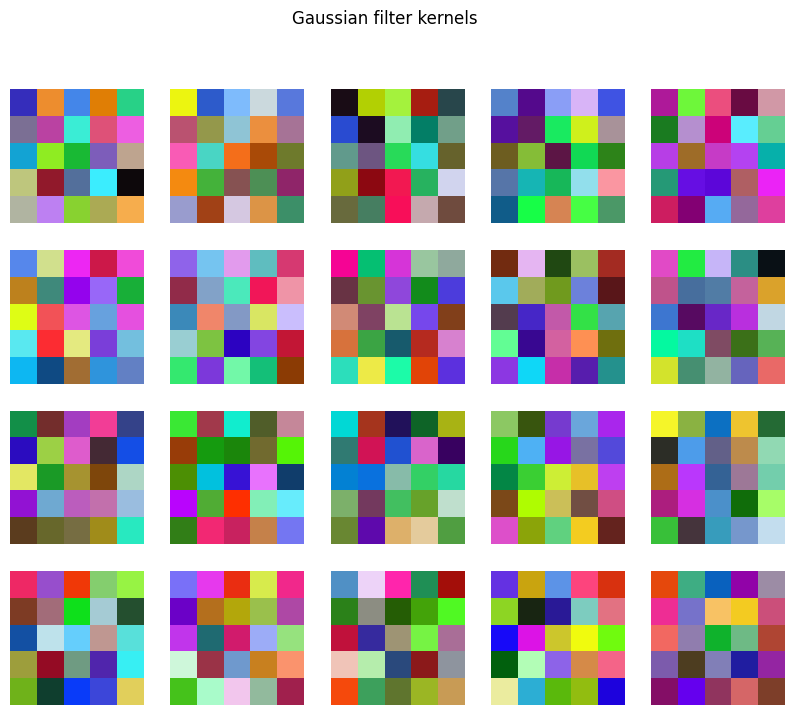

In [6]:
# conv_layer = Convolution_Layer(input_channels=3, output_channels=20, filter_size=5, bias=True, stride=1, padding=2, dilation=1)
# gaussian_weights = np.load('C0_weights.npy')
# conv_layer.set_weights(gaussian_weights)

# fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
# for i, ax in enumerate(axes.flat):
#     ax.imshow(gaussian_weights[i].transpose(1, 2, 0))
#     ax.axis('off')
# plt.suptitle("Gaussian filter kernels")
# plt.show()
conv_layer = Convolution_Layer(input_channels=3, output_channels=20, filter_size=5, bias=True, stride=1, padding=2, dilation=1)
gaussian_weights = np.load('C0_weights.npy')
gaussian_weights_norm = (gaussian_weights - np.min(gaussian_weights)) / (np.max(gaussian_weights) - np.min(gaussian_weights))
conv_layer.set_weights(gaussian_weights_norm)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(gaussian_weights_norm[i].transpose(1, 2, 0))
    ax.axis('off')
plt.suptitle("Gaussian filter kernels")
plt.show()


### Generate output for the first 5 images of the training set

In [7]:
# WRITE CODE HERE

# Here, X[:5] selects the first 5 images from the CIFAR-10 dataset, and X[:5].transpose(0, 3, 1, 2)
# changes the shape of the input from (5, 32, 32, 3) to (5, 3, 32, 32), which is the format required by 
# the convolution layer. conv_layer.forward performs forward propagation to compute the outputs of the 
# layer for the given input. The resulting outputs variable will have shape (5, 20, 32, 32), 
# where 5 is the number of input images, 20 is the number of output channels, and 32x32 is the size of the output feature maps.

outputs = conv_layer.forward(X[:5].transpose(0, 3, 1, 2))

### Use matplotlib to show the input and corresponding blurred output

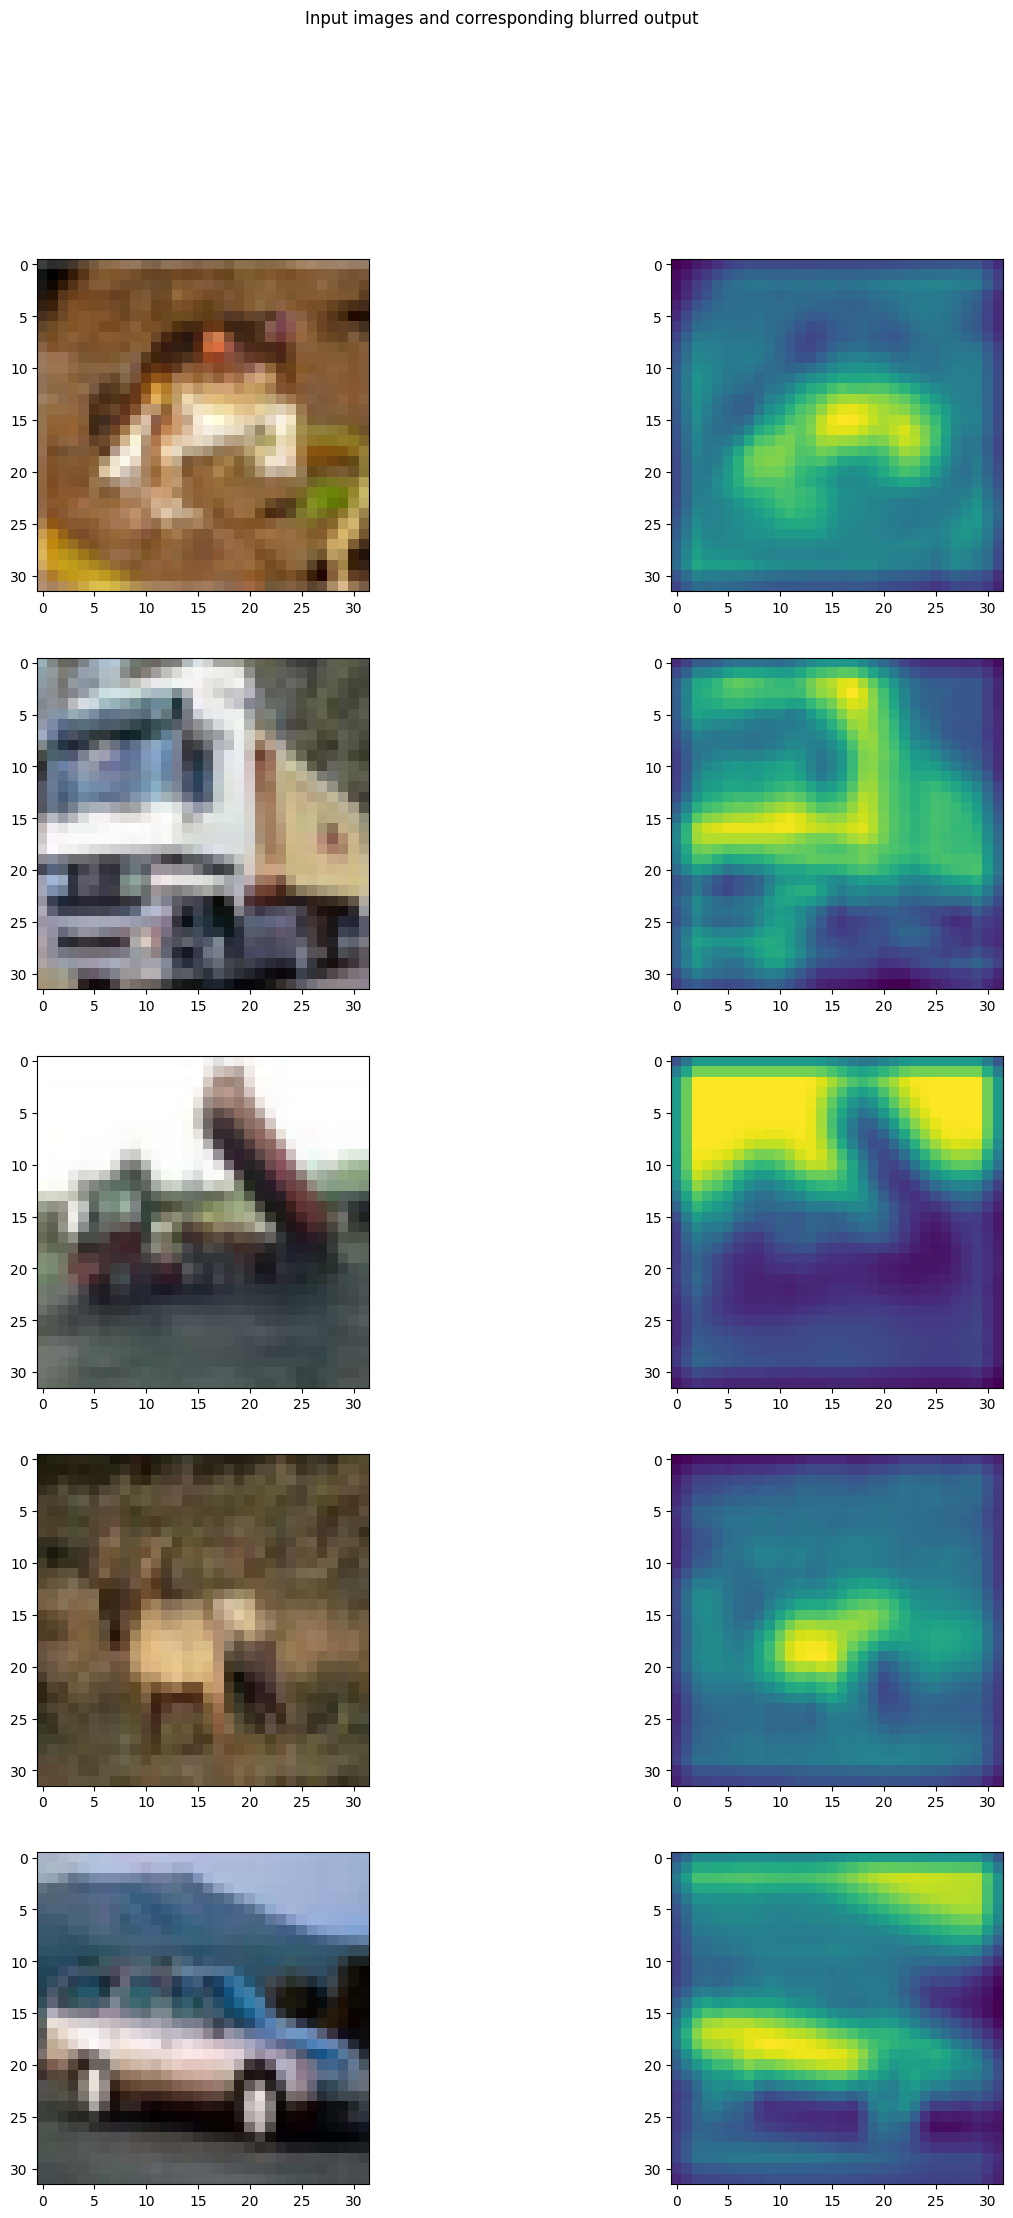

In [8]:
# WRITE CODE HERE

# create a figure with 5 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

# loop over the first 5 images in the training set
for i, ax in enumerate(axes):
    ax[0].imshow(X[i].astype(int))
    ax[1].imshow(outputs[i, 0].astype(int))
    
# set the title and display the figure
plt.suptitle("Input images and corresponding blurred output")
plt.show()


## Question 5
<br>
Now we will use this module for training a simple Convolution Layer using CIFAR-10 images. 

* The goal is to learn a set of weights, by using the backpropagation function created. To test the backpropagation, instead of training a whole network, we will train only a single layer.
  * Instantiate a Convolution  layer $C_0$ with 20 filters, each with size 5$\times$5 (RGB image, so 3 input channels). Load the given numpy array of size (20,3,5,5), which represents the weights of a convolution layer. Set the given values as the filter weights for $C_0$. Take 100 CIFAR-10 images. Save the output of these 100 images generated from this Convolution layer $C_0$. 
  
  * Now, initialize a new convolution layer $C$ with weight values sampled from uniform distribution [-1,1]. Use the $L_2$ loss between the output of this layer $C$ and the output generated in the previous step to learn the filter weights of $C_0$.


In [88]:
# ## Define a class Convolution Layer, which is initialized with the various required params:

# From previous question (convolution module)

import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import pickle

# Define a class Convolution Layer
class Convolution_Layer():
    
    def __init__(self, input_channels, output_channels, filter_size, bias=True, stride=1, padding=0, dilation=1):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        
        # For an untrained layer, set random initial filter weights and bias
        self.weights = np.random.randn(output_channels, input_channels, filter_size, filter_size)
        self.bias = np.random.randn(output_channels)
        
        # if bias:
        #     self.bias = np.random.randn(output_channels)
        # else:
        #     self.bias = None

        self.weights_grad = np.zeros(self.weights.shape)  # Define weights_grad attribute with initial value of 0
        self.biases_grad = np.zeros(self.bias.shape)
         
        
    def forward(self, input):
        # Input Preprocess(According to pad etc.) Input will be of size (Batch_size, in_channels, inp_height, inp_width)
        batch_size, in_channels, inp_height, inp_width = input.shape
        
        # Reminder: Save Input for backward-prop
        self.input = input
        
        # Pad the input
        padded_input = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        
        # Compute the output dimensions
        out_height = int(((inp_height + 2 * self.padding - self.dilation * (self.filter_size - 1) - 1) / self.stride) + 1)
        out_width = int(((inp_width + 2 * self.padding - self.dilation * (self.filter_size - 1) - 1) / self.stride) + 1)
        
        # Initialize the output
        output = np.zeros((batch_size, self.output_channels, out_height, out_width))
        
        # Simple Conv operation:
        # Loop over every location in inp_height * inp_width for the whole batch
        for i in range(batch_size):
            for j in range(self.output_channels):
                for k in range(out_height):
                    for l in range(out_width):
                        output[i, j, k, l] = np.sum(padded_input[i, :, k*self.stride:k*self.stride+self.filter_size, l*self.stride:l*self.stride+self.filter_size] * self.weights[j]) + self.bias[j] if self.bias is not None else 0
        
        # Output will be of the size (Batch_size, out_channels, out_height, out_width)
        return output
    
    def backward(self, grad_of_output_size):
        # Naive Implementation
        # Speed is not a concern
        # Hint: gradients from each independent operation can be summed
        
        batch_size, out_channels, out_height, out_width = grad_of_output_size.shape
        
        # Initialize the gradient with respect to the weights
        grad_weights = np.zeros((self.output_channels, self.input_channels, self.filter_size, self.filter_size))
        
       # Initialize the gradient with respect to the bias
        if self.bias is not None:
            grad_bias = np.zeros(self.output_channels)
        else:
            grad_bias = None
       

        # Pad the input and the gradient
        padded_input = np.pad(self.input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        padded_grad = np.pad(grad_of_output_size, ((0,0), (0,0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
            
            # Initialize the gradient with respect to the input
        grad_input = np.zeros_like(padded_input)
    
        # Loop over every location in out_height * out_width for the whole batch
        for i in range(batch_size):
            for j in range(self.output_channels):
                for k in range(out_height):
                    for l in range(out_width):
                        # Compute the gradients with respect to the weights and the bias
                        grad_weights[j] += padded_input[i, :, k*self.stride:k*self.stride+self.filter_size, l*self.stride:l*self.stride+self.filter_size] * grad_of_output_size[i, j, k, l]
                        if self.bias is not None:
                            grad_bias[j] += grad_of_output_size[i, j, k, l]
                    
                        # Compute the gradients with respect to the input
                        grad_input[i, :, k*self.stride:k*self.stride+self.filter_size, l*self.stride:l*self.stride+self.filter_size] += self.weights[j] * grad_of_output_size[i, j, k, l]
    
        # Remove the padding from the gradient with respect to the input
        grad_input = grad_input[:, :, self.padding:-self.padding, self.padding:-self.padding]
    
        #  return gradient of the size of the weight kernel
        return grad_input, grad_weights, grad_bias

    def set_weights(self, new_weights):
        ## Replace the set of weights with the given 'new_weights' file named 'C0_weights.npy' which has a shape (20,3,5,5)
        ## use this for setting weights for blurring, bilateral filtering etc. 
        self.weights = new_weights



In [89]:
import numpy as np

# Define a class L2 loss
class L2_loss():
    def __init__(self):
        pass
    
    def forward(self, C0_output, C_output):
        # Conv. output is of dimension (batchsize, channels, height, width)
        # Calculate the L2 norm of (C0_output - C_output)
        #The forward method calculates the L2 loss by first computing the element-wise difference between C0_output and C_output.
        
        loss = np.linalg.norm(C0_output - C_output)
        return loss
    
    def backward(self, C0_output, C_output):
        # From the loss, and the conv. output, get the grad at each location
        # The grad is of the shape (batchsize, channels, height, width)
        grad = 2 * (C_output - C0_output)
        return grad
    
    

In [90]:
# Load cifar data
X, Y = load_cifar_batch('./cifar-10-batches-py/data_batch_1')

# Normalize X here
X = X / 255.0


# Load the weights
#Load filter weights from the given numpy array "C0_weights.npy"
C0_weights = np.load('C0_weights.npy')
C0_weights_norm = (C0_weights - np.min(C0_weights)) / (np.max(C0_weights) - np.min(C0_weights))

# Init the given layer
#Instantiate a Convolution layer C0 with 20 filters, each with size 5×5 (RGB image, so 3 input channels)
C0 = Convolution_Layer(input_channels=3, output_channels=20, filter_size=5, stride=1, padding=2)

#Load the given numpy array of size (20,3,5,5), which represents the weights of a convolution layer
C0.set_weights(C0_weights_norm)

## Take 100 CIFAR-10 images. Save the output of these 100 images generated from this Convolution layer C0.
#Take 100 CIFAR-10 images

# Now get the outputs for the first 100 images
#Get output for these 100 images from Convolution Layer C0
num_images = 100
C0_output = C0.forward(X[:num_images].transpose(0, 3, 1, 2))

# Now for the training part
# Init a new layer
#Now initialize a new convolution layer C with weight values sampled from uniform distribution [-1,1]. 
#Use the L2 loss between the output of this layer C and the output generated in the previous step to learn the filter weights of C0.

#C = Convolution_Layer(input_channels=3, output_channels=20, filter_size=5, stride=1, padding=2)
C = Convolution_Layer(input_channels=3, output_channels=20, filter_size=5, bias=True, stride=1, padding=2, dilation=1)
C.set_weights(np.random.uniform(-1, 1, size=(20, 3, 5, 5)))




In [91]:
# Init a L2 Loss layer
l2_loss = L2_loss()


# Now we start the training

# Gradient clipping function (to handle exploding gradient)
def clip_grads(grads, max_value):
    return np.clip(grads, -max_value, max_value)

# Set the learning rate and max gradient value
learning_rate = 0.001
max_grad = 1.0

# Now we start the training

# Define batch size
batch_size = 2
num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0
    
    for i in range(0, num_images, batch_size):  
        # Forward pass through C_0
        C0_output = C0.forward(X[i:i+batch_size].transpose(0, 3, 1, 2))

        # Forward pass through new conv layer C
        C_output = C.forward(X[i:i+batch_size].transpose(0, 3, 1, 2))

        # Calculate loss
        loss = l2_loss.forward(C0_output, C_output)
        
        # Average the loss over the batch and add to total loss
        avg_loss = np.mean(loss)
        total_loss += avg_loss
        num_batches += 1

        # Backward pass
        output_grad = l2_loss.backward(C0_output, C_output)

        # Backward pass through conv layer
        input_grad, weights_grad, bias_grad = C.backward(output_grad)
        
        # Clip gradients to prevent explosion
        weights_grad = clip_grads(weights_grad, max_grad)
        bias_grad = clip_grads(bias_grad, max_grad)

        # Average the gradients over the batch
        avg_weights_grad = np.mean(weights_grad, axis=0)
        avg_bias_grad = np.mean(bias_grad, axis=0) if bias_grad is not None else None

        # Update weights and bias
        C.weights -= learning_rate * avg_weights_grad
        if C.bias is not None:
            C.bias -= learning_rate * avg_bias_grad

    # Calculate the average loss for this epoch
    avg_epoch_loss = total_loss / num_batches
    print(f'Epoch: {epoch+1}, Loss: {avg_epoch_loss}')


Epoch: 1, Loss: 3406.4556877210857
Epoch: 2, Loss: 3060.4667489450103
Epoch: 3, Loss: 2716.0443053338568
Epoch: 4, Loss: 2373.8744479057223
Epoch: 5, Loss: 2035.102461652807
Epoch: 6, Loss: 1701.7790683307173
Epoch: 7, Loss: 1380.8083927512553
Epoch: 8, Loss: 1096.271585205508
Epoch: 9, Loss: 870.8115110173909
Epoch: 10, Loss: 715.6132954301881
Epoch: 11, Loss: 634.2771693656113
Epoch: 12, Loss: 605.9096779055584
Epoch: 13, Loss: 598.7799730179888
Epoch: 14, Loss: 596.4367649655385
Epoch: 15, Loss: 595.5624717705869
Epoch: 16, Loss: 595.180158529826
Epoch: 17, Loss: 594.9645660676912
Epoch: 18, Loss: 594.8193256489079
Epoch: 19, Loss: 594.7036872775682
Epoch: 20, Loss: 594.6018513102359


In [92]:
# Print L2 dist between output from the new trained convolution layer C and the outputs generated from C_0.
C0_output = C0.forward(X[:100].transpose(0, 3, 1, 2))
C_output = C.forward(X[:100].transpose(0, 3, 1, 2))
l2_dist = np.linalg.norm(C0_output - C_output)  # final L2 loss (eucledian distance)
print(f'Final L2 distance between C and C0 outputs: {l2_dist}')


Final L2 distance between C and C0 outputs: 4230.661719475999


In [93]:
print(np.linalg.norm(C.weights - C0_weights))


36.17199078802804
